# <center> TP4 : Improve the Metropolis-Hastings algorithm </center>

#### Realized by: Samar Rabeh- GRP2


---

#### Imports

In [1]:

from scipy.stats import norm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
import warnings
warnings.simplefilter("ignore")
plt.rcParams['figure.figsize'] = 15, 8

In [2]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

---

## Exercise 1 : <center> Adaptive Metropolis-Hastings within Gibbs sampler

### 1.A – Metropolis-Hastings within Gibbs sampler

We aim to sample the target distribution $\pi$, on $\mathbb{R}^2$, given by:
    
$$(x,y) \rightarrow \pi(x,y) \sim exp(-\frac{x^2}{a^2}-y^2 -\frac{1}{4} (\frac{x^2}{a^2} -y^2)^2)$$

where $a > 0$. We consider a Markov transition kernel $P$ defined by: 

$$P=\frac{1}{2} (P_1+P_2)$$

where $P_i((x,y);dx´ \times dy´)$ for $i=1,2$ is the Markov transition kernel which only updates the $i$-th component: this update follows a symmetric random walk proposal mechanism and uses a Gaussian distribution with variance $\sigma_i^2$.

#### Question1.

In this question, we'll implement an algorithm that samples the distribution $P_1(z;.)$ where $z \in \mathbb{R}^2$ ; likewise for the distribution $P_2(z;.)$.
Then we'll implement an algorithm that samples a chain with kernel $P$.

**Define target distribution.** / **Contour plot of the density .**

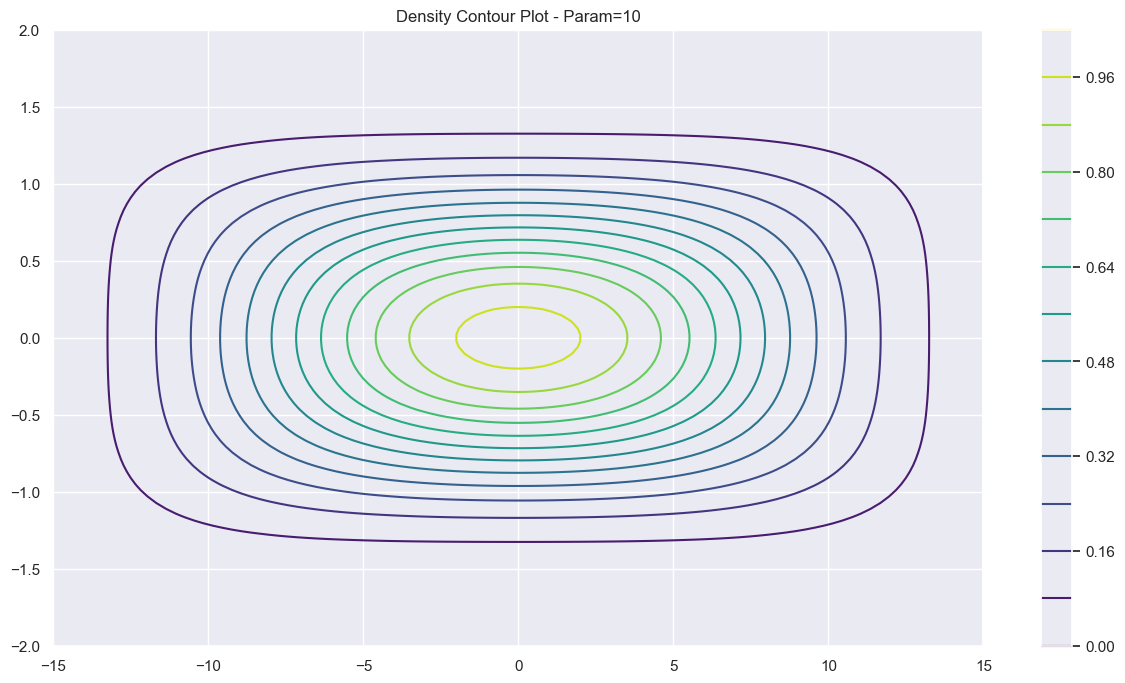

In [3]:
def compute_density(u, v, param):
    # Calculate the density function for the given inputs
    return np.exp(- u**2 / param**2 - v**2 - 1/4 * (u**2 / param**2 - v**2)**2)

def plot_contour(density_function):
    # Define ranges for the axes
    u_vals = np.linspace(-15, 15, 100)
    v_vals = np.linspace(-2, 2, 100)
    
    # Create a mesh grid from the ranges
    U, V = np.meshgrid(u_vals, v_vals)
    
    # Compute the density for the grid
    Density = density_function(U, V, param=10)
    
    # Plot the contour
    plt.contour(U, V, Density, 12, cmap='viridis')  # Adjusted color scheme
    plt.colorbar()
    plt.title('Density Contour Plot - Param=10')  # Changed title
    plt.show()

# Generate the plot using the updated function
plot_contour(compute_density)


* **Algorithm to sample $P_1(z;.)$.**

In [5]:
def metropolis_update(start_x, fixed_y, proposal_sd, hyperparam):
    '''
    # Inputs:
    start_x: initial value of x
    fixed_y: constant value of y while updating x
    proposal_sd: standard deviation for the proposal distribution
    hyperparam: parameter for the target distribution
    
    # Outputs:
    new_x: updated state of x
    acceptance_prob: probability of accepting the new state
    '''
    
    # Generate a candidate value for x from the proposal distribution
    candidate_x = np.random.normal(start_x, proposal_sd)
    
    # Calculate the logarithmic acceptance ratio
    log_accept_ratio = (
        np.log(compute_density(candidate_x, fixed_y, hyperparam)) 
        - np.log(compute_density(start_x, fixed_y, hyperparam))
    )
    
    # Draw a random value from a uniform distribution (log scale)
    log_uniform_sample = np.log(np.random.rand())
    
    # Accept or reject the candidate based on the acceptance rule
    if log_uniform_sample <= min(0, log_accept_ratio):
        # Accept the candidate state
        return candidate_x, min(1, np.exp(log_accept_ratio))
    else:
        # Reject the candidate and stay at the current state
        return start_x, min(1, np.exp(log_accept_ratio))


* **Algorithm to sample $P_2(z;.)$.**

In [6]:
def metropolis_y_update(fixed_x, start_y, proposal_sd_y, hyperparam):
    '''
    # Inputs:
    fixed_x: constant value of x while updating y
    start_y: initial value of y
    proposal_sd_y: standard deviation for the proposal distribution
    hyperparam: parameter for the density function
    
    # Outputs:
    new_y: updated state of y
    acceptance_prob: probability of accepting the new state
    '''
    
    # Generate a candidate value for y from the proposal distribution
    candidate_y = np.random.normal(start_y, proposal_sd_y)
    
    # Calculate the logarithmic acceptance ratio
    log_accept_ratio = (
        np.log(compute_density(fixed_x, candidate_y, hyperparam)) 
        - np.log(compute_density(fixed_x, start_y, hyperparam))
    )
    
    # Sample a random value from a uniform distribution (log scale)
    log_random_sample = np.log(np.random.rand())
    
    # Apply the acceptance rule to decide if the candidate is accepted
    if log_random_sample <= min(0, log_accept_ratio):
        # Candidate is accepted
        return candidate_y, min(1, np.exp(log_accept_ratio))
    else:
        # Candidate is rejected
        return start_y, min(1, np.exp(log_accept_ratio))


* **Algorithm to sample a chain with kernel $P$.**

In [7]:
def metropolis_hastings(initial_x, initial_y, hyperparam, sd_x, sd_y, num_samples):
    '''
    # Inputs:
    initial_x: starting value for the x parameter
    initial_y: starting value for the y parameter
    hyperparam: parameter of the target density
    sd_x: standard deviation for the x proposal distribution
    sd_y: standard deviation for the y proposal distribution
    num_samples: total number of samples to generate
    
    # Outputs:
    samples: array of selected (x, y) pairs
    accept_rates_x: list of acceptance rates for x updates
    accept_rates_y: list of acceptance rates for y updates
    '''
    
    # Initialize samples and starting points
    all_samples = np.zeros((2, num_samples))
    all_samples[0, 0] = initial_x
    all_samples[1, 0] = initial_y

    # Initialize acceptance rate trackers
    accept_rates_x = []
    accept_rates_y = []
    
    # Loop through the number of samples
    for sample_idx in range(1, num_samples):
        random_choice = np.random.rand()
        
        if random_choice < 0.5:
            # Update the x component
            updated_x, accept_rate = metropolis_update(initial_x, initial_y, sd_x, hyperparam)
            
            # Keep y unchanged, update x in samples
            all_samples[0, sample_idx] = updated_x
            all_samples[1, sample_idx] = initial_y
            
            # Record acceptance rate for x
            if sample_idx % 50 == 0:
                accept_rates_x.append(accept_rate)
            
            # Update the current x
            initial_x = updated_x
        
        else:
            # Update the y component
            updated_y, accept_rate = metropolis_y_update(initial_x, initial_y, sd_y, hyperparam)
            
            # Keep x unchanged, update y in samples
            all_samples[0, sample_idx] = initial_x
            all_samples[1, sample_idx] = updated_y
            
            # Record acceptance rate for y
            if sample_idx % 50 == 0:
                accept_rates_y.append(accept_rate)
            
            # Update the current y
            initial_y = updated_y

    return all_samples, accept_rates_x, accept_rates_y


#### Question2.

$a=10$ and $(\sigma_1,\sigma_2)=(3,3)$.

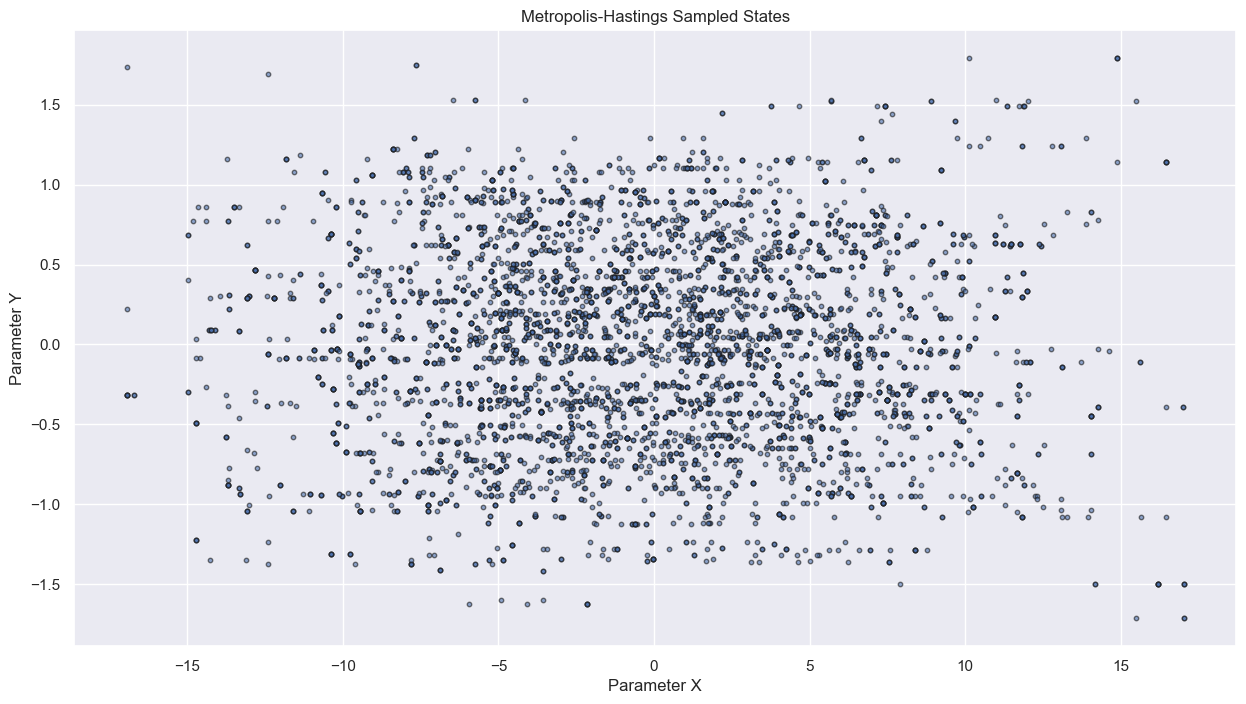

In [8]:
# Apply the Metropolis-Hastings sampling algorithm
sampled_data = metropolis_hastings(
    initial_x=1, 
    initial_y=0, 
    hyperparam=10, 
    sd_x=3, 
    sd_y=3, 
    num_samples=5000
)[0]

# Visualize the results of the sampling
plt.scatter(sampled_data[0, :], sampled_data[1, :], alpha=0.6, edgecolors='k', s=10)
plt.xlabel('Parameter X')
plt.ylabel('Parameter Y')
plt.title('Metropolis-Hastings Sampled States')
plt.grid(True)
plt.show()


**Observation:**

* It is evident that, with the chosen parameters, particularly the proposal variances $(\sigma_1, \sigma_2)$, the algorithm exhibits poor performance and fails to accurately sample from the target distribution.






#### Question3.

In this question, we try to improve the performance of the above algorithm. This can be done by varying the hyper-parameters of the Metropolis-Hastings algorithm to sample from $\pi$ with $a$ fixed to $10$.



**Useful functions.**

In [10]:
def plot_scatter(sampled_points):
    """
    Create a scatter plot of the sampled points.
    """
    plt.scatter(sampled_points[0, :], sampled_points[1, :], alpha=0.6, edgecolors='k', s=10)
    plt.xlabel('Parameter X')
    plt.ylabel('Parameter Y')
    plt.title('Scatter Plot of Sampled Points')
    plt.grid(True)
    plt.show()

def plot_autocorrelation(sampled_points):
    """
    Plot the autocorrelation of sampled points for both X and Y parameters.
    """
    pd.plotting.autocorrelation_plot(pd.DataFrame(sampled_points[0, :]), label='Autocorrelation of X')
    pd.plotting.autocorrelation_plot(pd.DataFrame(sampled_points[1, :]), label='Autocorrelation of Y')
    plt.legend()
    plt.xlim((0, 100))
    plt.title('Autocorrelation Plot of Sampled Points')
    plt.grid(True)
    plt.show()

def compute_mean_acceptance_rate(
    num_experiments=20, 
    mh_type='initial', 
    sample_size=2000, 
    total_iterations=500000, 
    plot_title=''
):
    """
    Compute and plot the mean acceptance rate over multiple runs of the algorithm.
    
    Parameters:
        num_experiments: Number of independent runs for averaging.
        mh_type: Type of Metropolis-Hastings ('initial' or 'adaptive').
        sample_size: Number of samples to consider for plotting the acceptance rate.
        total_iterations: Total number of iterations for each run.
        plot_title: Title for the acceptance rate plot.
    """
    # Initialize arrays to store acceptance rates for X and Y
    acceptance_rates_x = np.zeros((num_experiments, sample_size))
    acceptance_rates_y = np.zeros((num_experiments, sample_size))
    
    # Perform multiple runs to compute acceptance rates
    for experiment_idx in tqdm(range(num_experiments)):
        if mh_type == 'adaptive':
            rates_x, rates_y = Adaptive_MH_P(x0=1, y0=0, a=10, sigma1=3, sigma2=3, n=total_iterations)[1:3]
        else:
            rates_x, rates_y = metropolis_hastings(x0=1, y0=0, hyperparam=10, sd_x=3, sd_y=3, num_samples=total_iterations)[1:3]
        
        # Store rates for the first `sample_size` samples
        acceptance_rates_x[experiment_idx, :] = rates_x[:sample_size]
        acceptance_rates_y[experiment_idx, :] = rates_y[:sample_size]
    
    # Plot the mean acceptance rates
    plt.plot(np.mean(acceptance_rates_x, axis=0), label='X Acceptance Rate')
    plt.plot(np.mean(acceptance_rates_y, axis=0), label='Y Acceptance Rate')
    plt.legend()
    plt.title('Mean Acceptance Rate ' + plot_title)
    plt.xlabel('Iterations')
    plt.ylabel('Acceptance Rate')
    plt.grid(True)
    plt.show()


**1. First method.** 

Choose different probabilities for samplers of directions x and y. We can choose for instance $P = \frac{3}{4} P_1 + \frac{1}{4} P_2$ instead of $ P = \frac{1}{2} (P_1 + P_2)$. <br> 

In [13]:
def metropolis_hastings_method1(initial_x, initial_y, hyperparam, sd_x, sd_y, num_samples):
    '''
    # Inputs:
    initial_x: starting value for parameter x
    initial_y: starting value for parameter y
    hyperparam: parameter for the target distribution
    sd_x: standard deviation for the x proposal distribution
    sd_y: standard deviation for the y proposal distribution
    num_samples: number of samples to generate
    
    # Outputs:
    sampled_pairs: array of selected (x, y) pairs
    '''
    
    # Initialize the array to store samples
    sampled_pairs = np.zeros((2, num_samples))
    sampled_pairs[0, 0] = initial_x
    sampled_pairs[1, 0] = initial_y
    
    # Generate samples through Metropolis-Hastings
    for sample_idx in range(1, num_samples):
        random_choice = np.random.rand()
        
        if random_choice < 0.75:
            # Update the x component
            updated_x = metropolis_update(initial_x, initial_y, sd_x, hyperparam)[0]
            
            # Keep y unchanged and store the updated x
            sampled_pairs[0, sample_idx] = updated_x
            sampled_pairs[1, sample_idx] = initial_y
            
            # Update current x value
            initial_x = updated_x
        else:
            # Update the y component
            updated_y = metropolis_y_update(initial_x, initial_y, sd_y, hyperparam)[0]
            
            # Keep x unchanged and store the updated y
            sampled_pairs[1, sample_idx] = updated_y
            sampled_pairs[0, sample_idx] = initial_x
            
            # Update current y value
            initial_y = updated_y

    return sampled_pairs


**Result:**

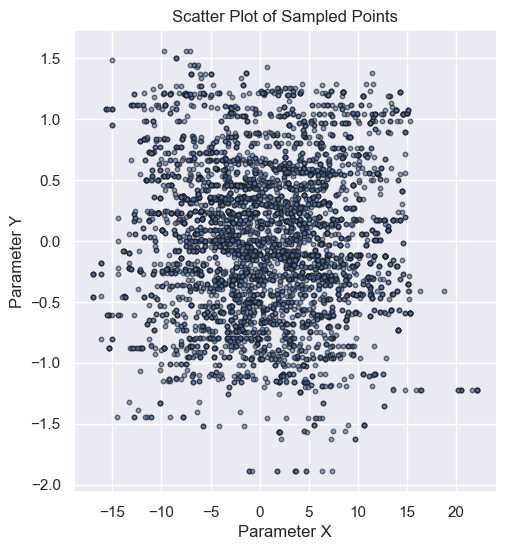

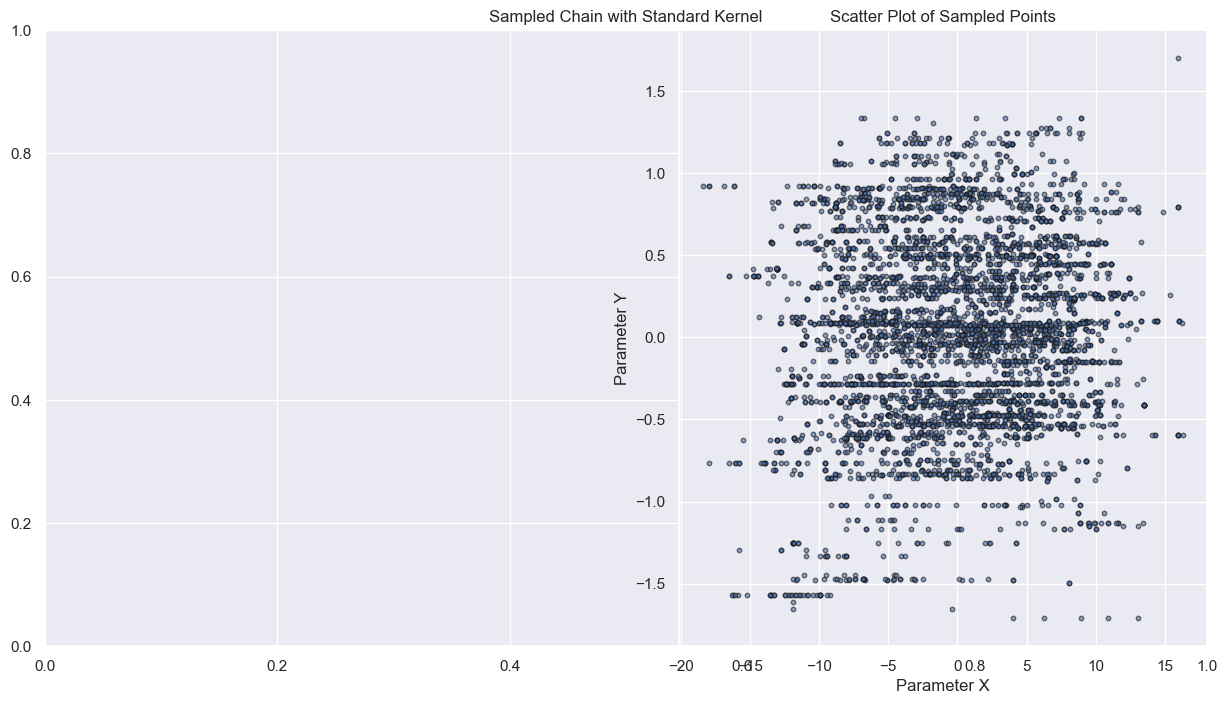

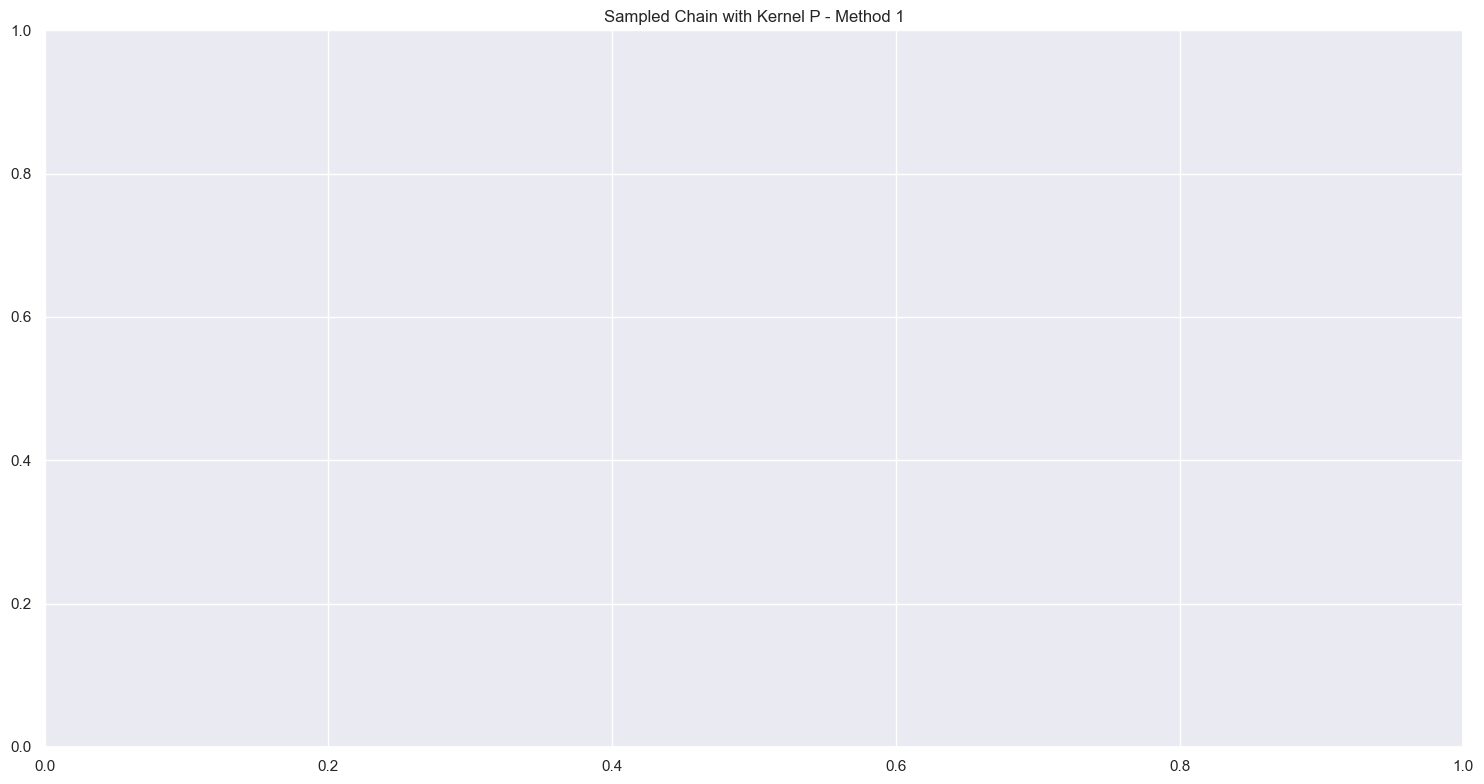

In [15]:
# Plot results of the initial Metropolis-Hastings method
plt.figure(figsize=(12, 6))

# Plot for the standard method
plt.subplot(1, 2, 1)
initial_samples = metropolis_hastings(
    initial_x=1, 
    initial_y=0, 
    hyperparam=10, 
    sd_x=3, 
    sd_y=3, 
    num_samples=5000
)[0]
plot_scatter(initial_samples)
plt.title('Sampled Chain with Standard Kernel')

# Plot for the modified method (Method 1)
plt.subplot(1, 2, 2)
method1_samples = metropolis_hastings_method1(
    initial_x=1, 
    initial_y=0, 
    hyperparam=10, 
    sd_x=3, 
    sd_y=3, 
    num_samples=5000
)
plot_scatter(method1_samples)
plt.title('Sampled Chain with Kernel P - Method 1')

plt.tight_layout()
plt.show()



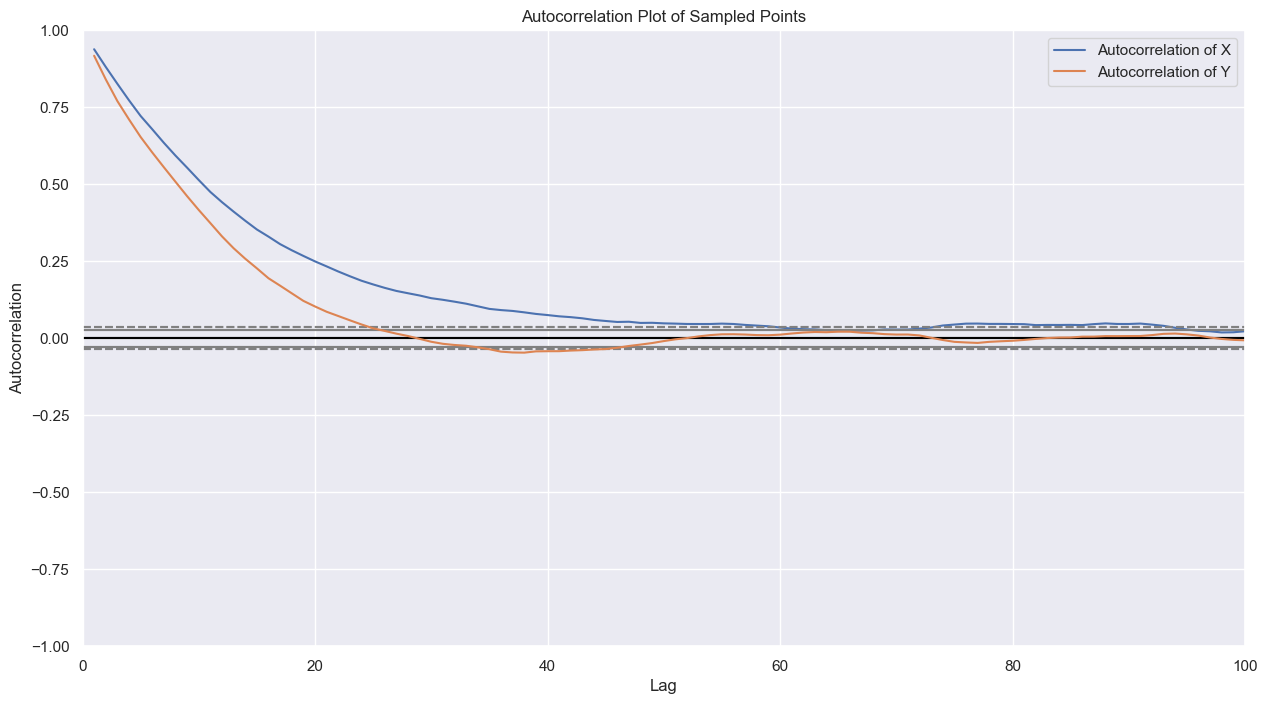

In [17]:
# Plot autocorrelation for the sampled data
plot_autocorrelation(method1_samples)


**Observations**:


The samples remain significantly distant from the desired target distribution.
While there is a strong correlation observed between the parameters x and y, the autocorrelation for each parameter individually appears to converge toward approximately 0.

**2. Second method.** 

Choose different values of standard deviation for each of the directions x and y. we can choose for instance $(\sigma_1, \sigma_2) = (5,1)$ instead of $(\sigma_1, \sigma_2) = (3,3).$ <br>

**Result:**

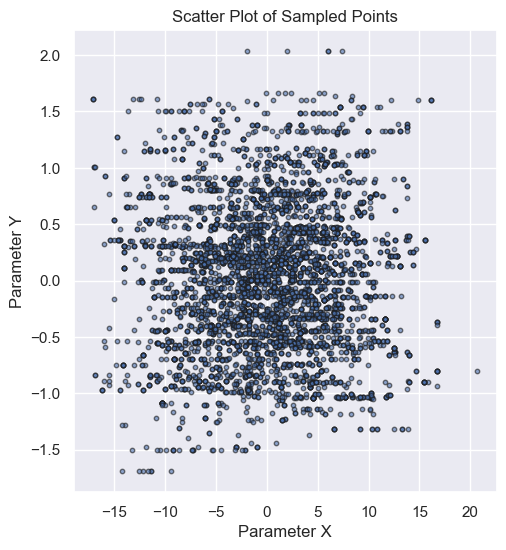

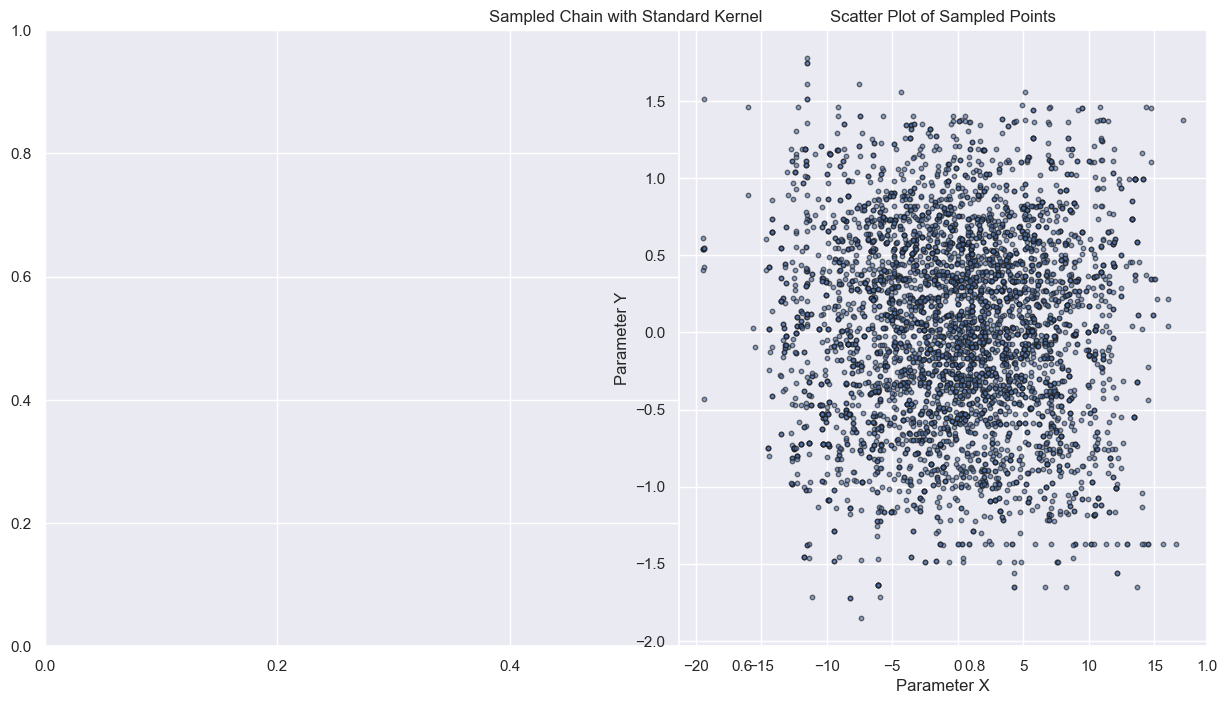

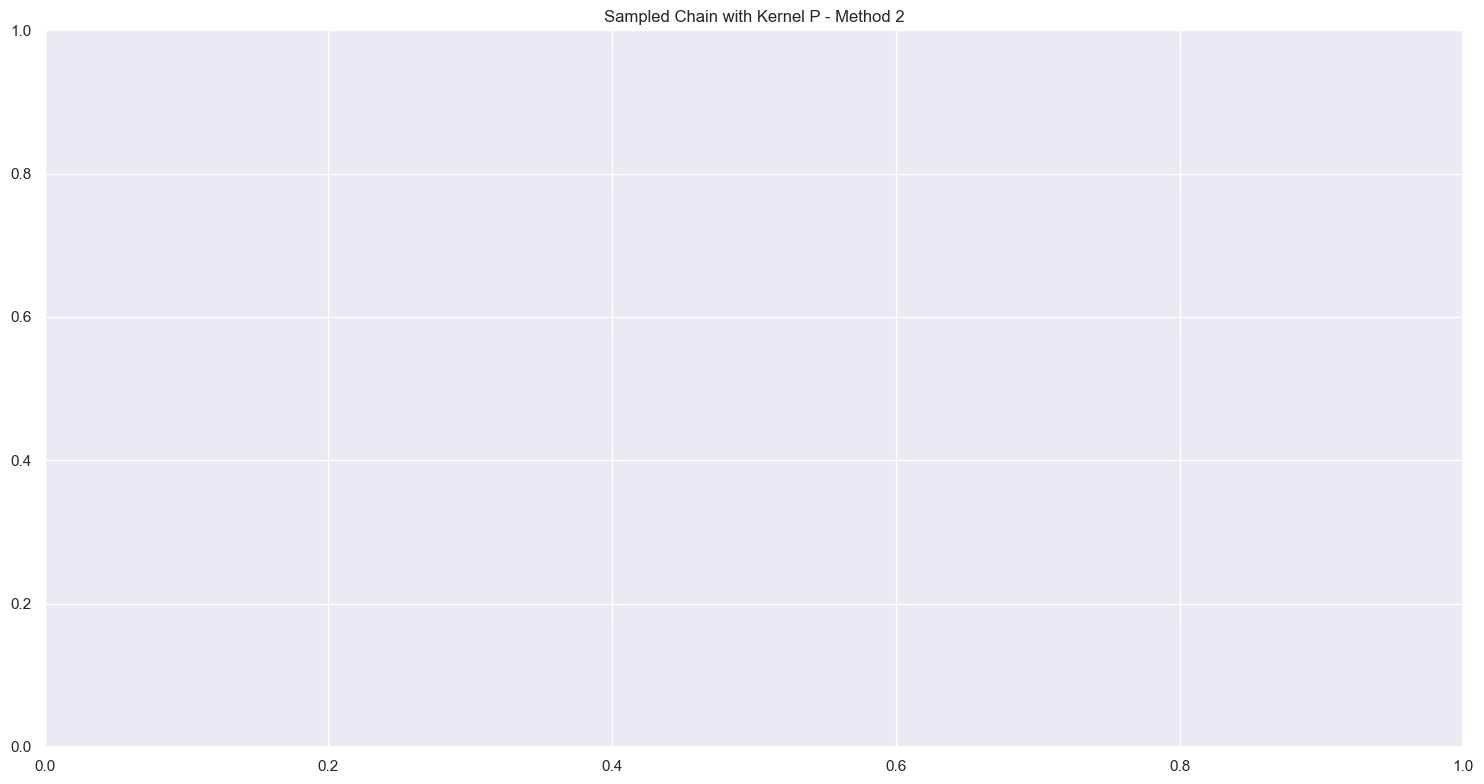

In [18]:
# Compare the results of the initial Metropolis-Hastings method and Method 2
plt.figure(figsize=(12, 6))

# Plot for the initial method
plt.subplot(1, 2, 1)
initial_samples = metropolis_hastings(
    initial_x=1, 
    initial_y=0, 
    hyperparam=10, 
    sd_x=3, 
    sd_y=3, 
    num_samples=5000
)[0]
plot_scatter(initial_samples)
plt.title('Sampled Chain with Standard Kernel')

# Plot for Method 2 with adjusted proposal variances
plt.subplot(1, 2, 2)
method2_samples, accept_rate_x, accept_rate_y = metropolis_hastings(
    initial_x=1, 
    initial_y=0, 
    hyperparam=10, 
    sd_x=5, 
    sd_y=1, 
    num_samples=5000
)
plot_scatter(method2_samples)
plt.title('Sampled Chain with Kernel P - Method 2')

plt.tight_layout()
plt.show()


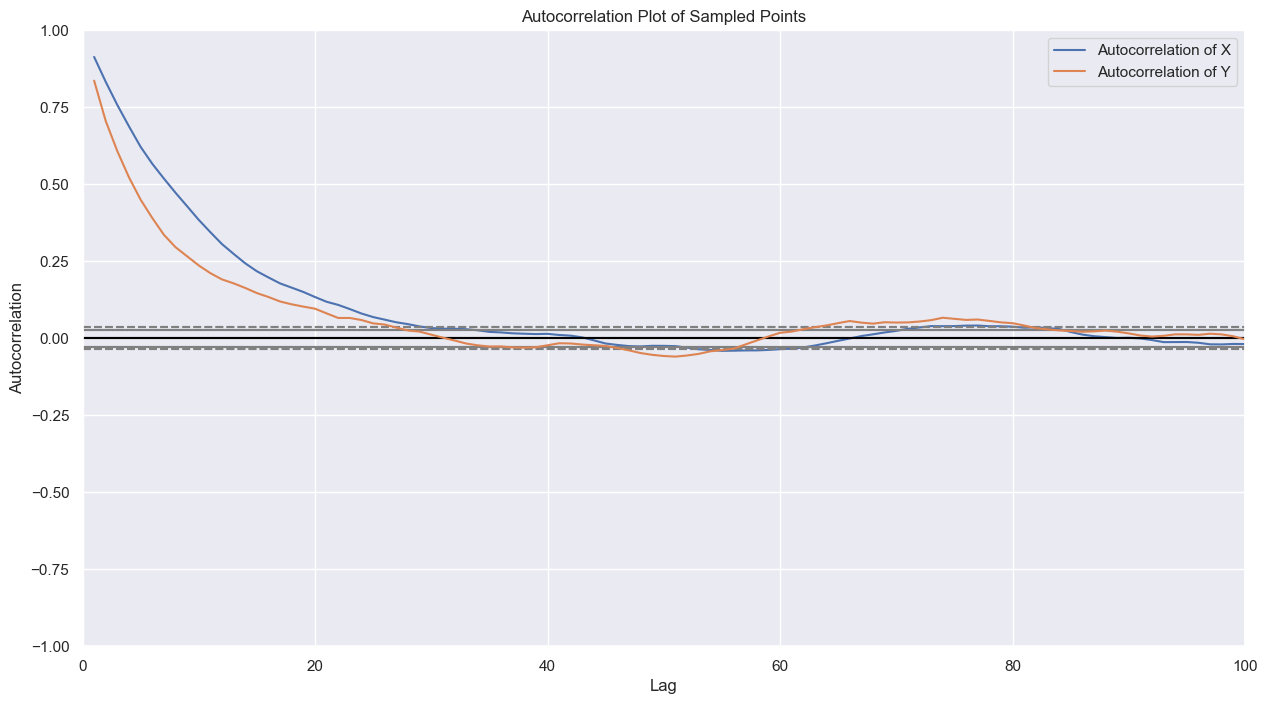

In [19]:
# Plot autocorrelation for the sampled data from Method 2
plot_autocorrelation(method2_samples)


**Observations:**

with the chosen parameters the samples are slightly better, but do not form the best combination. 
so tuning the associated parameters such as proposal variances is crucial to achieve efficient mixing.

**Acceptance Rate .**


In [21]:
# Calculate and plot the mean acceptance rate for the initial Metropolis-Hastings method
compute_mean_acceptance_rate(
    num_experiments=20, 
    mh_type='initial', 
    sample_size=2000, 
    total_iterations=500000, 
    plot_title='(Initial Method)'
)


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

### 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

In this part, we introduce and adaptive version of the above sampler which is a class of MCMC algorithms that address the problem of parameters tuning by updating automatically some of (if not all) the parameters while automatically “learning” better parameter values. This would therefore adjust the variances of the proposal distributions.


#### Question1.

In this first question, we implement the adaptative Metropolis-Hastings within Gibbs sampler to test on
the density $\pi$ defined in part $A$.


**Adaptive-algorithm to sample $P_1(z,.)$.**

In [22]:
def adaptive_metropolis_update_x(current_x, fixed_y, proposal_sd_x, hyperparam):
    '''
    # Inputs:
    current_x: starting value for the x parameter
    fixed_y: constant value for the y parameter during x updates
    proposal_sd_x: standard deviation of the x proposal distribution
    hyperparam: parameter of the target distribution
    
    # Outputs:
    updated_x: new state of x after the update
    acceptance_prob: probability of accepting the new state
    is_accepted: flag indicating whether the proposal was accepted (1) or not (0)
    '''
    
    # Propose a candidate value for x
    proposed_x = np.random.normal(current_x, proposal_sd_x)
    
    # Calculate the logarithmic acceptance ratio
    log_accept_ratio = (
        np.log(compute_density(proposed_x, fixed_y, hyperparam)) 
        - np.log(compute_density(current_x, fixed_y, hyperparam))
    )
    
    # Sample a random value (log scale) to determine acceptance
    log_random_sample = np.log(np.random.rand())
    
    if log_random_sample <= min(0, log_accept_ratio):
        # Accept the candidate
        return proposed_x, min(1, np.exp(log_accept_ratio)), 1
    else:
        # Reject the candidate and retain the current state
        return current_x, min(1, np.exp(log_accept_ratio)), 0


**Adaptive-algorithm to sample $P_2(z,.)$.**

In [23]:
def adaptive_metropolis_update_y(fixed_x, current_y, proposal_sd_y, hyperparam):
    '''
    # Inputs:
    fixed_x: constant value for the x parameter during y updates
    current_y: starting value for the y parameter
    proposal_sd_y: standard deviation of the y proposal distribution
    hyperparam: parameter of the target distribution
    
    # Outputs:
    updated_y: new state of y after the update
    acceptance_prob: probability of accepting the new state
    is_accepted: flag indicating whether the proposal was accepted (1) or not (0)
    '''
    
    # Propose a candidate value for y
    proposed_y = np.random.normal(current_y, proposal_sd_y)
    
    # Calculate the logarithmic acceptance ratio
    log_accept_ratio = (
        np.log(compute_density(fixed_x, proposed_y, hyperparam)) 
        - np.log(compute_density(fixed_x, current_y, hyperparam))
    )
    
    # Sample a random value (log scale) to determine acceptance
    log_random_sample = np.log(np.random.rand())
    
    if log_random_sample <= min(0, log_accept_ratio):
        # Accept the candidate
        return proposed_y, min(1, np.exp(log_accept_ratio)), 1
    else:
        # Reject the candidate and retain the current state
        return current_y, min(1, np.exp(log_accept_ratio)), 0


**Adaptive-algorithm to sample $P$.**

In [24]:
def adaptive_metropolis_sampling(
    initial_x, initial_y, hyperparam, sd_x, sd_y, num_samples
):
    '''
    # Inputs:
    initial_x: starting value for parameter x
    initial_y: starting value for parameter y
    hyperparam: parameter of the target distribution
    sd_x: initial standard deviation for x proposal distribution
    sd_y: initial standard deviation for y proposal distribution
    num_samples: total number of samples to generate
    
    # Outputs:
    samples: array of generated (x, y) pairs
    acceptance_rates_x: list of acceptance probabilities for x updates (every 50 iterations)
    acceptance_rates_y: list of acceptance probabilities for y updates (every 50 iterations)
    '''
    
    # Initialize samples array
    sampled_pairs = np.zeros((2, num_samples))
    sampled_pairs[0, 0] = initial_x
    sampled_pairs[1, 0] = initial_y
    
    # Logarithmic scale for proposal variances
    log_sd_x = 0
    log_sd_y = 0
    
    # Batch counter
    batch_counter = 0
    
    # Track acceptance rates
    accept_count_x = 0
    accept_count_y = 0
    
    acceptance_rates_x = []
    acceptance_rates_y = []
    
    # Generate samples
    for sample_idx in range(1, num_samples):
        random_choice = np.random.rand()
        
        if random_choice < 0.5:
            # Update x
            updated_x, accept_prob, is_accepted = adaptive_metropolis_update_x(
                initial_x, initial_y, np.exp(log_sd_x), hyperparam
            )
            
            # Update x in samples and acceptance count
            sampled_pairs[0, sample_idx] = updated_x
            sampled_pairs[1, sample_idx] = initial_y
            accept_count_x += is_accepted
            
            if sample_idx % 50 == 0:
                acceptance_rates_x.append(accept_prob)
            
            # Update current x
            initial_x = updated_x
        else:
            # Update y
            updated_y, accept_prob, is_accepted = adaptive_metropolis_update_y(
                initial_x, initial_y, np.exp(log_sd_y), hyperparam
            )
            
            # Update y in samples and acceptance count
            sampled_pairs[0, sample_idx] = initial_x
            sampled_pairs[1, sample_idx] = updated_y
            accept_count_y += is_accepted
            
            if sample_idx % 50 == 0:
                acceptance_rates_y.append(accept_prob)
            
            # Update current y
            initial_y = updated_y
        
        # Adjust proposal variances every 50 iterations
        if sample_idx % 50 == 0:
            batch_counter += 1
            delta = min(0.01, batch_counter**(-0.5))
            
            if accept_count_x / 50 > 0.24:
                log_sd_x += delta
            else:
                log_sd_x -= delta
                
            if accept_count_y / 50 > 0.24:
                log_sd_y += delta
            else:
                log_sd_y -= delta
            
            # Reset acceptance counts
            accept_count_x = 0
            accept_count_y = 0

    return sampled_pairs, acceptance_rates_x, acceptance_rates_y


**Results:**

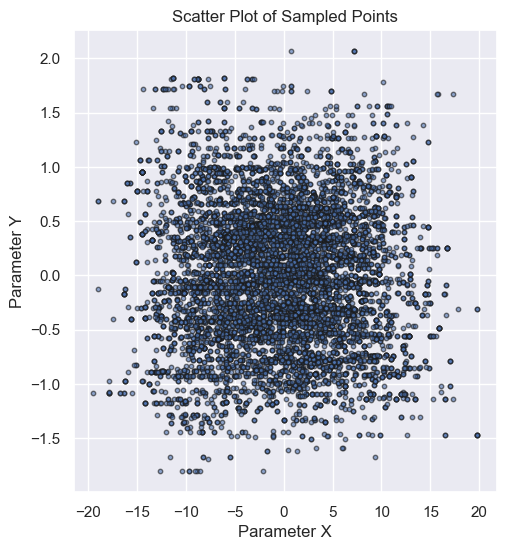

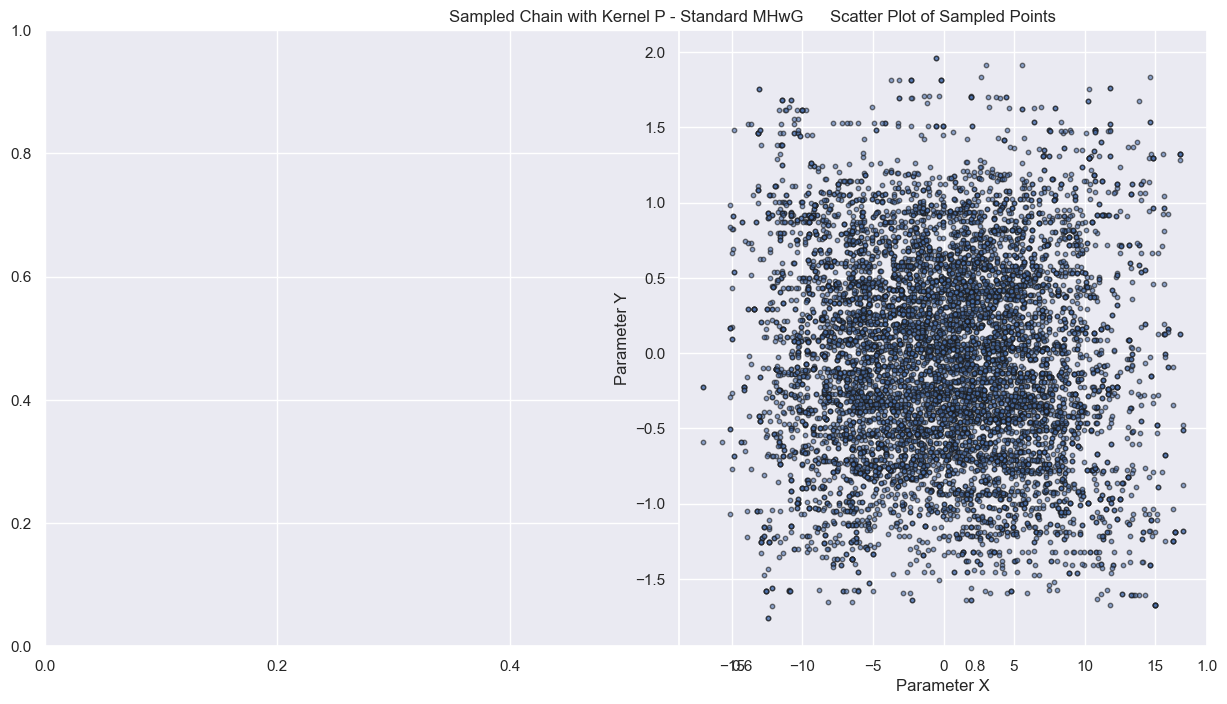

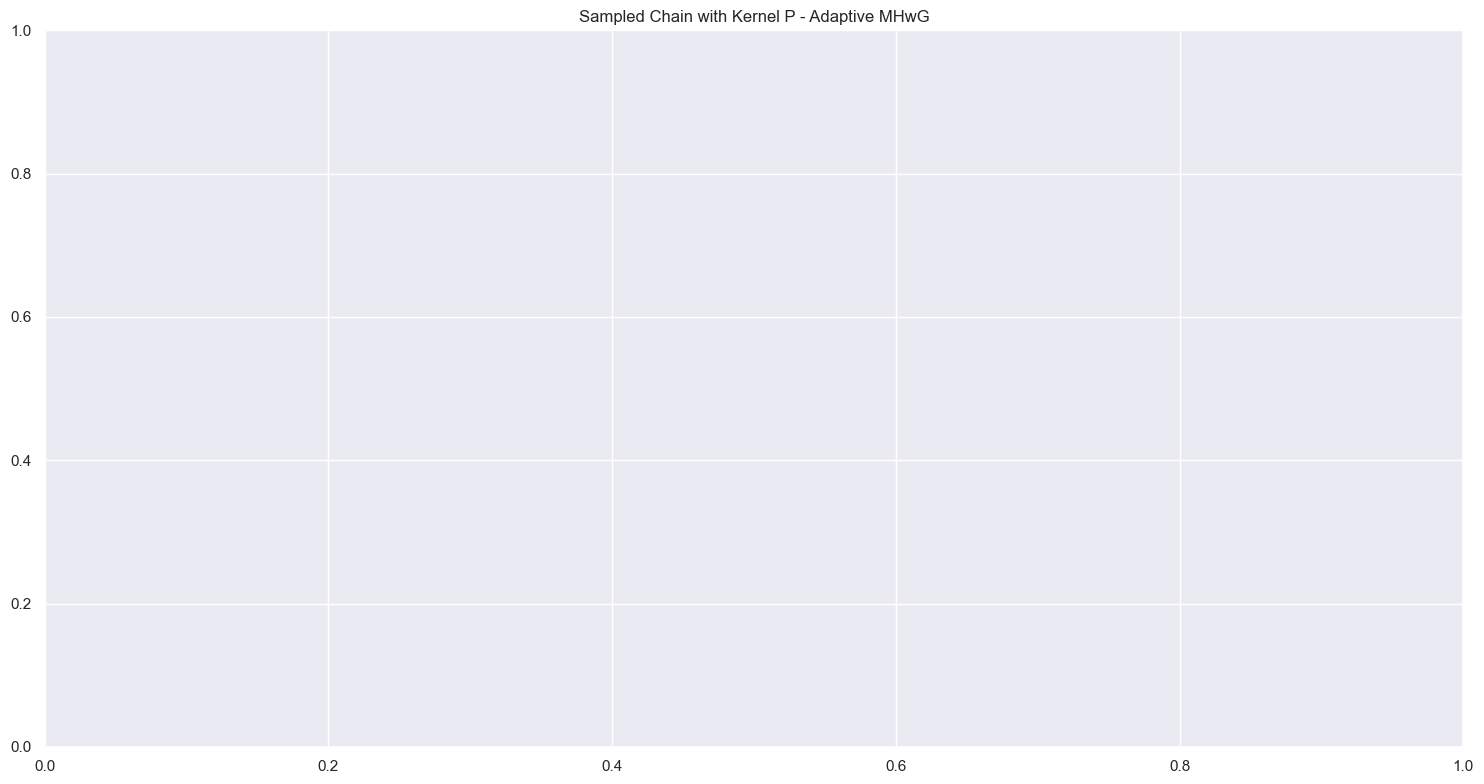

In [ ]:
# Compare the results of the standard and adaptive Metropolis-Hastings algorithms
plt.figure(figsize=(12, 6))

# Plot for the standard Metropolis-Hastings algorithm
plt.subplot(1, 2, 1)
mhwg_samples = metropolis_hastings(
    initial_x=0, 
    initial_y=0, 
    hyperparam=10, 
    sd_x=3, 
    sd_y=3, 
    num_samples=10000
)[0]
plot_scatter(mhwg_samples)
plt.title('Sampled Chain with Kernel P - Standard MHwG')

# Plot for the adaptive Metropolis-Hastings algorithm
plt.subplot(1, 2, 2)
adaptive_samples, accept_rate_x, accept_rate_y = adaptive_metropolis_sampling(
    initial_x=0, 
    initial_y=0, 
    hyperparam=10, 
    sd_x=3, 
    sd_y=3, 
    num_samples=10000
)


plt.tight_layout()
plt.show()


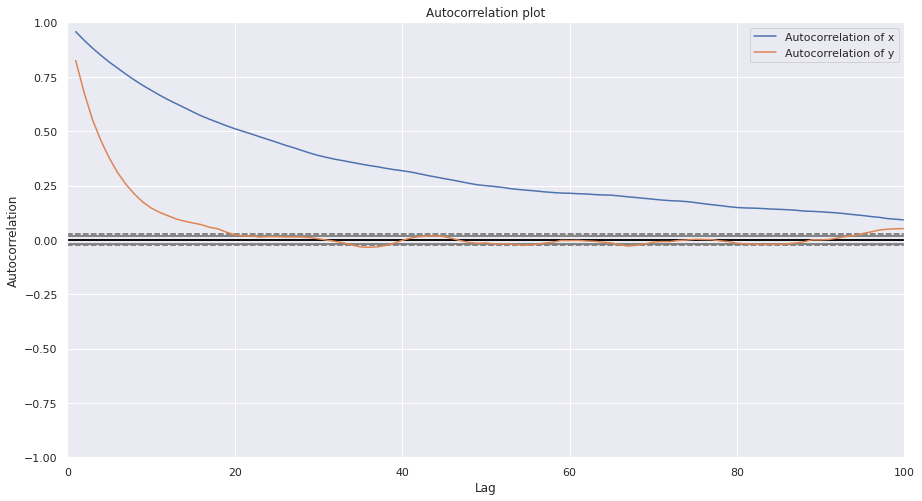

In [26]:
autocorrelation(samples)

**Observations:**

* the samples converge correctly to the target distribution.
* The auto-correlation of $y$ converges in much fewer iterations than the auto-correlation of $x$.

In [ ]:
from tqdm import tqdm


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Calculate and plot the mean acceptance rate for the adaptive Metropolis-Hastings method
compute_mean_acceptance_rate(
    num_experiments=20, 
    mh_type='adaptive', 
    sample_size=2000, 
    total_iterations=500000, 
    plot_title='(Adaptive Method)'
)


Exception ignored in: <function tqdm.__del__ at 0x127271700>
Traceback (most recent call last):
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x127271700>
Traceback (most recent call last):
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

#### Question2.

In this question, we compare the performance of our algorithm on more complicated target densities.

For example, centered $d$-dimentional Gaussian $N(0,\Sigma)$ or "banana"-shaped density as in TP $2$:

$$\forall x = (x_1, ..., x_d) \in \mathbb{R}^d, ~~~f_B(x) \propto exp(-\frac{x_1^2}{200}-\frac{1}{2}(x_2 + B x_1^2 -100B)^2 - \frac{1}{2}(x_3^2 + ... + x_d^2))$$

In practice, we choose $d=20$ and the $20 \times 20$ variance-covariance matrix $\Sigma$ given in http://dept.stat.lsa.umich.edu/~yvesa/tmalaexcov.txt.

**Centered d-dimentional gaussian:**

In [35]:
# Chosen parameters
dimension = 20
banana_coefficient = 2

# Load variance-covariance matrix from file
with open("tmcov.txt", "r") as file:
    lines = file.readlines()
    covariance_matrix = np.array([list(map(float, line.split())) for line in lines])

# Create a zero-mean vector for a centered Gaussian
mean_vector = np.zeros(dimension)

# Generate samples from a multivariate normal distribution
gaussian_samples = np.random.multivariate_normal(
    mean=mean_vector, cov=covariance_matrix, size=10000
)

# Apply a nonlinear transformation to the second component for a "banana" shape
gaussian_samples[:, 1] += (
    banana_coefficient * gaussian_samples[:, 0]**2 - 100 * banana_coefficient
)

# Plot the first two dimensions of the transformed samples
plt.figure(figsize=(8, 6))
plt.scatter(gaussian_samples[:, 0], gaussian_samples[:, 1], alpha=0.6, edgecolors="k", s=10)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title('Transformed "Banana"-Shaped Density')
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'tmcov.txt'

**Comment:**

* The samples generated from the multivariate normal distribution with the given $\sigma$ and the corresponding shift of the second variable correspond indeed to a banana-shape distribution.

**density distribution $f_B$.**

In [36]:
def compute_banana_density(x, banana_coeff):

    # Compute the transformed second component
    second_component = x[1] + banana_coeff * x[0]**2 - 100 * banana_coeff
    
    # Compute the density
    density = np.exp(
        -x[0]**2 / 200
        - 0.5 * second_component**2
        - 0.5 * np.sum(x[2:]**2)
    )
    
    return density


**Adaptive MH algorithm for "Banana"-shaped density.**

In [37]:
import copy

def metropolis_hastings_banana(current_x, proposal_sd, dimension, banana_coeff, update_index):
   
    # Propose a new candidate by perturbing the specified component
    proposed_x = copy.deepcopy(current_x)
    proposed_x[update_index] = np.random.normal(current_x[update_index], proposal_sd)

    # Compute the logarithmic acceptance ratio
    log_accept_ratio = (
        np.log(compute_banana_density(proposed_x, banana_coeff)) 
        - np.log(compute_banana_density(current_x, banana_coeff))
    )
    
    # Determine acceptance or rejection
    log_random_value = np.log(np.random.rand())
    if log_random_value <= min(0, log_accept_ratio):
        # Accept the proposed state
        return proposed_x, 1
    else:
        # Reject the proposal and keep the current state
        return current_x, 0


In [38]:
def adaptive_metropolis_hastings_banana(initial_x, dimension, banana_coeff, num_samples):

    # Initialize samples array
    samples = np.zeros((dimension, num_samples))
    samples[:, 0] = initial_x

    # Initialize logarithmic scale for proposal variances
    log_proposal_sd = np.zeros(dimension)
    
    # Batch counter for adaptive updates
    batch_counter = 0
    
    # Initialize acceptance rates
    acceptance_rate = np.zeros(dimension)

    # Generate samples
    for sample_idx in range(1, num_samples):
        
        # Randomly select a component to update
        update_index = np.random.randint(dimension)
        
        # Perform Metropolis-Hastings update for the chosen component
        initial_x, is_accepted = metropolis_hastings_banana(
            current_x=initial_x, 
            proposal_sd=np.exp(log_proposal_sd[update_index]), 
            dimension=dimension, 
            banana_coeff=banana_coeff, 
            update_index=update_index
        )
        
        # Store the updated state
        samples[:, sample_idx] = copy.deepcopy(initial_x)
        
        # Update acceptance rate for the chosen component
        acceptance_rate[update_index] += is_accepted

        # Adjust proposal variances every 50 iterations
        if sample_idx % 50 == 0:
            batch_counter += 1
            delta = min(0.01, batch_counter**(-0.5))
            for dim in range(dimension):
                if acceptance_rate[dim] / 50 > 0.24:
                    log_proposal_sd[dim] += delta
                else:
                    log_proposal_sd[dim] -= delta
            
            # Reset acceptance rates for the next batch
            acceptance_rate = np.zeros(dimension)

    return samples


**Results:**

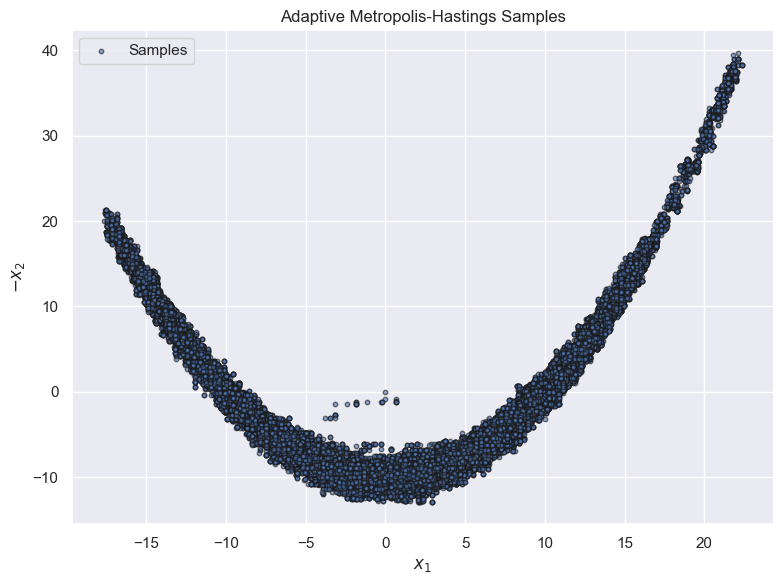

In [39]:
# Apply the adaptive Metropolis-Hastings algorithm
x0 = np.zeros(3)
samples = adaptive_metropolis_hastings_banana(initial_x=x0, dimension=3, banana_coeff=0.1, num_samples=100000)

# Plot the first two dimensions of the generated samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[0, :], -samples[1, :], alpha=0.6, edgecolors="k", s=10, label="Samples")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$-x_2$")
plt.title('Adaptive Metropolis-Hastings Samples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Plot the autocorrelation for the generated samples
plot_autocorrelation(samples)

**Observations:**

*the generated samples are form a banana shape. 

---

## Exercise 2 : <center> Sampling from multimodal distributions

In this exercise, we'll consider a multimodal distribution as the target distribution. We show in the first part that the conventional Metropolis-Hastings cannot sample from this kind of distribution, nor its adaptive version.
Thus, in the second part, the Parallel Tempering comes into play. This latter is a generic Markov chain Monte Carlo sampling method which, as we'll see, allows good mixing with multimodal target distributions.

### 2.A – A toy example

In [42]:
# Parameters
weights = [0.05] * 20
variances = [0.1] * 20
means = np.array([
    [2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82], 
    [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40], 
    [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50], 
    [4.93, 1.50], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]
])

# Define the multimodal target distribution
def target_distribution_mixture(x, weights, variances, means):
    """
    Computes the multimodal target distribution as a mixture of Gaussian components.
    
    Parameters:
    - x: A numpy array representing the point of evaluation.
    - weights: List of weights for each Gaussian component.
    - variances: List of variances for each Gaussian component.
    - means: Array of mean vectors for each Gaussian component.
    
    Returns:
    - The computed probability density at point x.
    """
    return sum([
        weights[i] / (2 * np.pi * variances[i]**2) * np.exp(
            -1 / (2 * variances[i]**2) * (np.array(x) - means[i]).T @ (np.array(x) - means[i])
        ) 
        for i in range(len(weights))
    ])


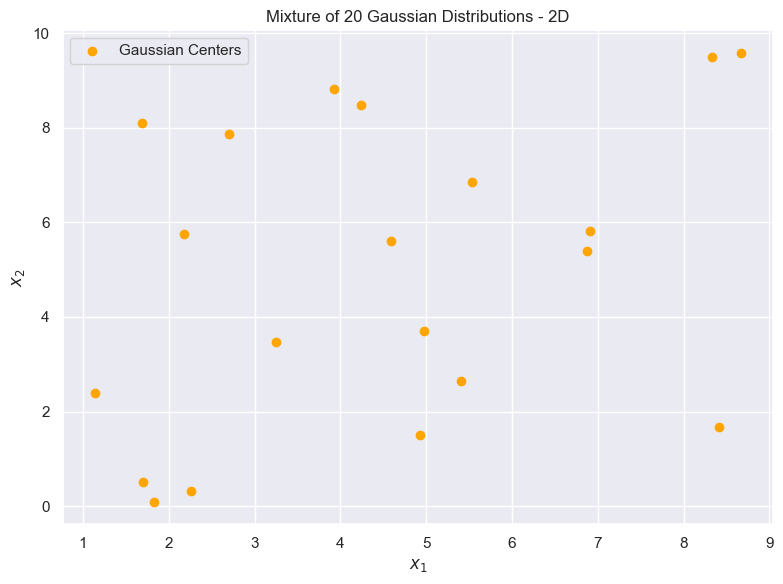

Exception ignored in: <function tqdm.__del__ at 0x127271700>
Traceback (most recent call last):
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x127271700>
Traceback (most recent call last):
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x127271700>
Traceback (most recent call last):
  File "/Users/samar/Library/Python/3.

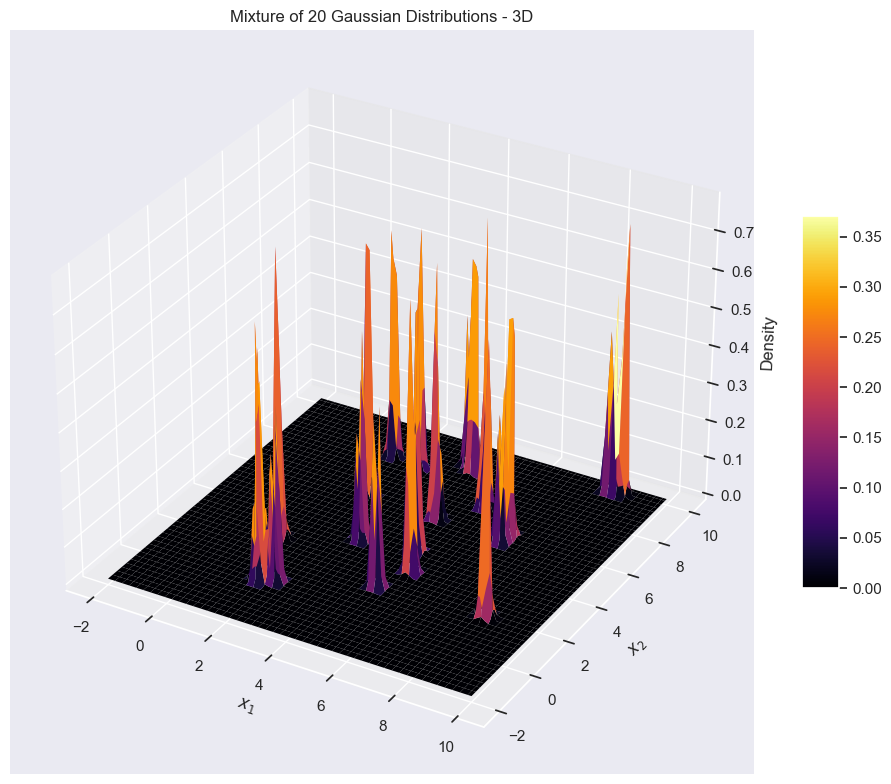

In [43]:
# Plot Mixture Gaussian in 2D
plt.figure(figsize=(8, 6))
plt.scatter(means[:, 0], means[:, 1], color='orange', label='Gaussian Centers')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Mixture of 20 Gaussian Distributions - 2D")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Mixture Gaussian in 3D
x, y = np.mgrid[-2.0:10.0:100j, -2.0:10.0:100j]
xy = np.column_stack([x.flat, y.flat])

# Compute target distribution values
z = np.array([target_distribution_mixture(xy[i], weights, variances, means) for i in range(xy.shape[0])])
z = z.reshape(x.shape)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
surface = ax.plot_surface(x, y, z, cmap='inferno', edgecolor='none')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel("Density")
ax.set_title("Mixture of 20 Gaussian Distributions - 3D")
fig.colorbar(surface, shrink=0.5, aspect=10)  # Add a color bar for the surface
plt.tight_layout()
plt.show()


#### Question1.

In this first question, we implement a Metropolis-Hastings Symmetric Random Walk algorithm to sample from the target distribution $\pi$.

In [44]:
def metropolis_hastings_multimodal_x(current_x, fixed_y, proposal_sd_x, weights, variances, means):
    """
    Performs a Metropolis-Hastings update for the x-component in a multimodal distribution.

    Parameters:
    - current_x: Current value of the x-component.
    - fixed_y: Fixed value of the y-component.
    - proposal_sd_x: Standard deviation of the proposal distribution for x.
    - weights: List of weights for each Gaussian component in the mixture.
    - variances: List of variances for each Gaussian component in the mixture.
    - means: Array of mean vectors for each Gaussian component.

    Returns:
    - updated_x: The updated value of the x-component.
    - is_accepted: Flag indicating whether the proposal was accepted (1) or rejected (0).
    """
    # Draw a candidate value from the proposal distribution
    proposed_x = np.random.normal(current_x, proposal_sd_x)
    
    # Compute the logarithmic acceptance ratio
    log_accept_ratio = (
        np.log(target_distribution_mixture([proposed_x, fixed_y], weights, variances, means))
        - np.log(target_distribution_mixture([current_x, fixed_y], weights, variances, means))
    )
    
    # Sample a random value to determine acceptance
    log_random_value = np.log(np.random.rand())
    
    # Determine whether to accept or reject the proposed state
    if log_random_value < min(0, log_accept_ratio):
        # Accept the proposed state
        return proposed_x, 1
    else:
        # Reject the proposal and keep the current state
        return current_x, 0


In [45]:
def metropolis_hastings_multimodal_y(fixed_x, current_y, proposal_sd_y, weights, variances, means):
    """
    Performs a Metropolis-Hastings update for the y-component in a multimodal distribution.

    Parameters:
    - fixed_x: Fixed value of the x-component.
    - current_y: Current value of the y-component.
    - proposal_sd_y: Standard deviation of the proposal distribution for y.
    - weights: List of weights for each Gaussian component in the mixture.
    - variances: List of variances for each Gaussian component in the mixture.
    - means: Array of mean vectors for each Gaussian component.

    Returns:
    - updated_y: The updated value of the y-component.
    - is_accepted: Flag indicating whether the proposal was accepted (1) or rejected (0).
    """
    # Draw a candidate value from the proposal distribution
    proposed_y = np.random.normal(current_y, proposal_sd_y)
    
    # Compute the logarithmic acceptance ratio
    log_accept_ratio = (
        np.log(target_distribution_mixture([fixed_x, proposed_y], weights, variances, means))
        - np.log(target_distribution_mixture([fixed_x, current_y], weights, variances, means))
    )
    
    # Sample a random value to determine acceptance
    log_random_value = np.log(np.random.rand())
    
    # Determine whether to accept or reject the proposed state
    if log_random_value < min(0, log_accept_ratio):
        # Accept the proposed state
        return proposed_y, 1
    else:
        # Reject the proposal and keep the current state
        return current_y, 0


In [46]:
def metropolis_hastings_multimodal(initial_x, initial_y, proposal_sd_x, proposal_sd_y, weights, variances, means, num_samples):
    """
    Performs Metropolis-Hastings sampling for a 2D multimodal distribution.

    Parameters:
    - initial_x: Initial value of the x-component.
    - initial_y: Initial value of the y-component.
    - proposal_sd_x: Standard deviation of the proposal distribution for x.
    - proposal_sd_y: Standard deviation of the proposal distribution for y.
    - weights: List of weights for each Gaussian component in the mixture.
    - variances: List of variances for each Gaussian component in the mixture.
    - means: Array of mean vectors for each Gaussian component.
    - num_samples: Total number of samples to generate.

    Returns:
    - samples: Array of generated samples (shape: [2, num_samples + 1]).
    """
    # Initialize samples array
    samples = np.zeros((2, num_samples + 1))
    samples[0, 0] = initial_x
    samples[1, 0] = initial_y

    # Initialize current states
    current_x, current_y = initial_x, initial_y

    # Generate samples
    for sample_idx in range(1, num_samples + 1):
        # Update the x-component
        updated_x, _ = metropolis_hastings_multimodal_x(
            current_x=current_x, 
            fixed_y=current_y, 
            proposal_sd_x=proposal_sd_x, 
            weights=weights, 
            variances=variances, 
            means=means
        )
        samples[0, sample_idx] = updated_x
        current_x = updated_x

        # Update the y-component
        updated_y, _ = metropolis_hastings_multimodal_y(
            fixed_x=current_x, 
            current_y=current_y, 
            proposal_sd_y=proposal_sd_y, 
            weights=weights, 
            variances=variances, 
            means=means
        )
        samples[1, sample_idx] = updated_y
        current_y = updated_y

    return samples


**Test algorithm:**

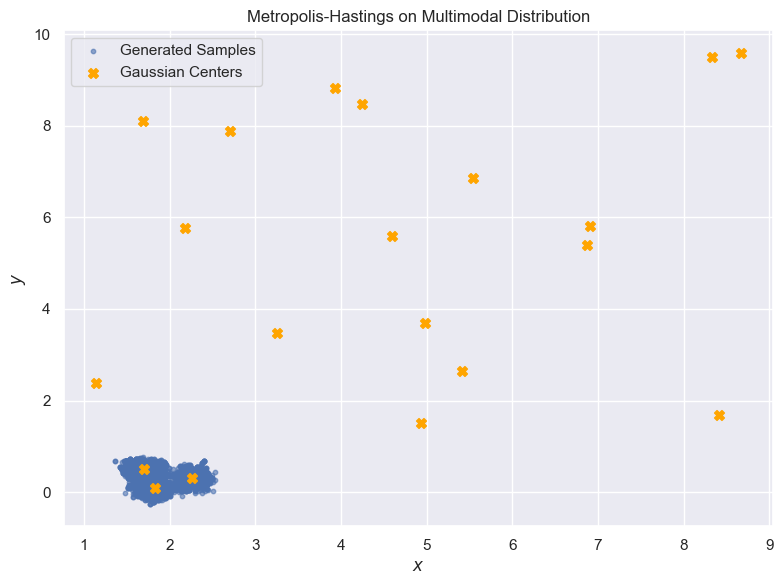

In [47]:
# Initialize parameters
initial_x = 0
initial_y = 0
num_samples = 10000
proposal_sd_x = 1
proposal_sd_y = 1

# Apply Metropolis-Hastings on the multimodal distribution
samples = metropolis_hastings_multimodal(
    initial_x=initial_x, 
    initial_y=initial_y, 
    proposal_sd_x=proposal_sd_x, 
    proposal_sd_y=proposal_sd_y, 
    weights=weights, 
    variances=variances, 
    means=means, 
    num_samples=num_samples
)

# Visualize generated samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[0, 2000:], samples[1, 2000:], label='Generated Samples', alpha=0.6, s=10)
plt.scatter(means[:, 0], means[:, 1], label='Gaussian Centers', color='orange', marker='X', s=50)
plt.title('Metropolis-Hastings on Multimodal Distribution')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Observation:**

* The algorithm merely samples from $3$ gaussians of a total of $20$ gaussians. 
* the Metropolis-Hastings algorithm doesn't perform well on multimodal distributions.

#### Question2.
In this question, we implement the adaptive Metropolis-Hastings Symmetric Random Walk algorithm to sample from the target distribution $\pi$.

In [50]:
def adaptive_metropolis_hastings_multimodal(initial_x, initial_y, weights, variances, means, num_samples):
    """
    Adaptive Metropolis-Hastings algorithm for a 2D multimodal distribution.

    Returns:
    - samples: Array of generated samples (shape: [2, num_samples + 1]).
    """
    # Initialize samples array
    samples = np.zeros((2, num_samples + 1))
    samples[0, 0] = initial_x
    samples[1, 0] = initial_y

    # Logarithmic scale for proposal variances
    log_proposal_sd_x = 0
    log_proposal_sd_y = 0

    # Batch counter for adaptive updates
    batch_counter = 0

    # Initialize acceptance rates
    acceptance_rate_x = 0
    acceptance_rate_y = 0

    # Initialize current states
    current_x, current_y = initial_x, initial_y

    # Generate samples
    for sample_idx in range(1, num_samples):
        # Update the x-component
        current_x, x_accepted = metropolis_hastings_multimodal_x(
            current_x=current_x, 
            fixed_y=current_y, 
            proposal_sd_x=np.exp(log_proposal_sd_x), 
            weights=weights, 
            variances=variances, 
            means=means
        )
        samples[0, sample_idx] = current_x
        acceptance_rate_x += x_accepted

        # Update the y-component
        current_y, y_accepted = metropolis_hastings_multimodal_y(
            fixed_x=current_x, 
            current_y=current_y, 
            proposal_sd_y=np.exp(log_proposal_sd_y), 
            weights=weights, 
            variances=variances, 
            means=means
        )
        samples[1, sample_idx] = current_y
        acceptance_rate_y += y_accepted

        # Adjust proposal variances every 50 iterations
        if sample_idx % 50 == 0:
            batch_counter += 1
            delta = min(0.01, batch_counter**(-0.5))

            # Adjust x-component variance
            if acceptance_rate_x / 50 > 0.24:
                log_proposal_sd_x += delta
            else:
                log_proposal_sd_x -= delta

            # Adjust y-component variance
            if acceptance_rate_y / 50 > 0.24:
                log_proposal_sd_y += delta
            else:
                log_proposal_sd_y -= delta

            # Reset acceptance rates for the next batch
            acceptance_rate_x = 0
            acceptance_rate_y = 0

    return samples


**Test algorithm:**


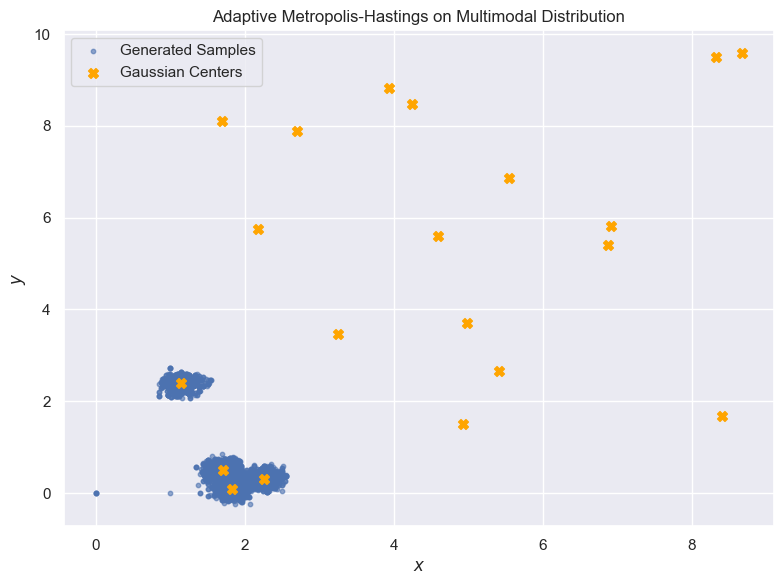

In [54]:
# Apply Adaptive Metropolis-Hastings
samples = adaptive_metropolis_hastings_multimodal(
    initial_x=0, 
    initial_y=0, 
    weights=weights, 
    variances=variances, 
    means=means, 
    num_samples=num_samples
)

# Visualize generated samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[0, :], samples[1, :], label='Generated Samples', alpha=0.6, s=10)
plt.scatter(means[:, 0], means[:, 1], label='Gaussian Centers', color='orange', marker='X', s=50)
plt.title('Adaptive Metropolis-Hastings on Multimodal Distribution')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Observation:**

the adaptive Metropolis-Hastings algorithm cannot neither sample correctly from $\pi$ even though it performs slightly better than the conventional Metropolis-Hastings. 

### 2.B – Parallel Tempering

#### Question1.

In this first question, we'll implement the Parallel Tempering algorithm considering the distribution $\pi$ of Part $A$, and for the Metropolis-Hastings step we take as proposal distribution the bivariate Gaussian distribution centered at $X_n^{(i)}$, with variance-covariance matrix $\tau_i^2I_2$:

$$\forall i \in [1,K], ~~~ Y_{n+1}^{(i)} \sim N_{\mathbb{R^2}}(X_n^{(i)}, \tau_i^2 I_2)~\text{where}~ \tau_i = 0.25 \sqrt{T_i}.$$

In [55]:
def metropolis_hastings_tempered_x(current_x, fixed_y, proposal_sd_x, weights, variances, means, temperature):
    """
    Performs a Metropolis-Hastings update for the x-component with tempered target distribution.

    Parameters:
    - current_x: Current value of the x-component.
    - fixed_y: Fixed value of the y-component.
    - proposal_sd_x: Standard deviation of the proposal distribution for x.
    - weights: List of weights for each Gaussian component in the mixture.
    - variances: List of variances for each Gaussian component in the mixture.
    - means: Array of mean vectors for each Gaussian component.
    - temperature: Temperature parameter for tempering the target distribution.

    Returns:
    - updated_x: The updated value of the x-component.
    """
    # Draw a candidate value from the proposal distribution
    proposed_x = np.random.normal(current_x, proposal_sd_x)
    
    # Compute the logarithmic acceptance ratio with tempering
    log_accept_ratio = (
        np.log(target_distribution_mixture([proposed_x, fixed_y], weights, variances, means)**(1 / temperature))
        - np.log(target_distribution_mixture([current_x, fixed_y], weights, variances, means)**(1 / temperature))
    )
    
    # Sample a random value to determine acceptance
    log_random_value = np.log(np.random.rand())
    
    # Determine whether to accept or reject the proposed state
    if log_random_value < min(0, log_accept_ratio):
        # Accept the proposed state
        return proposed_x
    else:
        # Reject the proposal and keep the current state
        return current_x


In [56]:
def metropolis_hastings_tempered_y(fixed_x, current_y, proposal_sd_y, weights, variances, means, temperature):
    """
    Performs a Metropolis-Hastings update for the y-component with tempered target distribution.

    Parameters:
    - fixed_x: Fixed value of the x-component.
    - current_y: Current value of the y-component.
    - proposal_sd_y: Standard deviation of the proposal distribution for y.
    - weights: List of weights for each Gaussian component in the mixture.
    - variances: List of variances for each Gaussian component in the mixture.
    - means: Array of mean vectors for each Gaussian component.
    - temperature: Temperature parameter for tempering the target distribution.

    Returns:
    - updated_y: The updated value of the y-component.
    """
    # Draw a candidate value from the proposal distribution
    proposed_y = np.random.normal(current_y, proposal_sd_y)
    
    # Compute the logarithmic acceptance ratio with tempering
    log_accept_ratio = (
        np.log(target_distribution_mixture([fixed_x, proposed_y], weights, variances, means)**(1 / temperature))
        - np.log(target_distribution_mixture([fixed_x, current_y], weights, variances, means)**(1 / temperature))
    )
    
    # Sample a random value to determine acceptance
    log_random_value = np.log(np.random.rand())
    
    # Determine whether to accept or reject the proposed state
    if log_random_value < min(0, log_accept_ratio):
        # Accept the proposed state
        return proposed_y
    else:
        # Reject the proposal and keep the current state
        return current_y


In [57]:
def metropolis_hastings_tempered_sampling(weights, variances, means, num_iterations, num_chains, temperatures):
    """
    Performs tempered Metropolis-Hastings sampling with parallel chains and swapping.

    Parameters:
    - weights: List of weights for each Gaussian component in the mixture.
    - variances: List of variances for each Gaussian component in the mixture.
    - means: Array of mean vectors for each Gaussian component.
    - num_iterations: Number of iterations for sampling.
    - num_chains: Number of parallel chains.
    - temperatures: List of temperatures for tempering.

    Returns:
    - samples: Array of generated samples (shape: [num_chains, 2, num_iterations + 1]).
    """
    # Initialize the samples array
    samples = np.zeros((num_chains, 2, num_iterations + 1))
    
    # Initialize x and y
    x0 = 0
    y0 = 0

    # Main sampling loop
    for n in range(num_iterations):
        # 1. Generate samples for each chain
        for i in range(num_chains):
            x0 = metropolis_hastings_tempered_x(
                current_x=x0, 
                fixed_y=y0, 
                proposal_sd_x=0.25 * np.sqrt(temperatures[i]), 
                weights=weights, 
                variances=variances, 
                means=means, 
                temperature=temperatures[i]
            )
            samples[i, 0, n + 1] = x0
            
            y0 = metropolis_hastings_tempered_y(
                fixed_x=x0, 
                current_y=y0, 
                proposal_sd_y=0.25 * np.sqrt(temperatures[i]), 
                weights=weights, 
                variances=variances, 
                means=means, 
                temperature=temperatures[i]
            )
            samples[i, 1, n + 1] = y0

        # 2. Choose uniformly (i, j)
        i = np.random.randint(1, num_chains - 1)
        j = i + 1 if np.random.rand() < 0.5 else i - 1

        # 3. Compute the logarithm of the acceptance probability for swapping
        log_alpha = (
            np.log(
                target_distribution_mixture(samples[i, :, n + 1], weights, variances, means) ** (1 / temperatures[j])
                * target_distribution_mixture(samples[j, :, n + 1], weights, variances, means) ** (1 / temperatures[i])
            )
            - np.log(
                target_distribution_mixture(samples[j, :, n + 1], weights, variances, means) ** (1 / temperatures[j])
                * target_distribution_mixture(samples[i, :, n + 1], weights, variances, means) ** (1 / temperatures[i])
            )
        )

        # 4. Swap with acceptance probability
        if np.log(np.random.rand()) <= log_alpha:
            # Swap the samples between chains i and j
            samples[i, :, n + 1], samples[j, :, n + 1] = samples[j, :, n + 1], samples[i, :, n + 1].copy()

    return samples


#### Question2.

In this question, we test our algorithm while considering $K = 5$ and the following temperatures ladder: $(T_1,...,T_5)=(60, 21.6, 7.7, 2.8, 1)$.

In [58]:
# Initialize temperature ladder
num_chains = 5
temperatures = np.array([60, 21.6, 7.7, 2.8, 1])

# Apply the tempered Metropolis-Hastings algorithm
num_iterations = 10000
samples = metropolis_hastings_tempered_sampling(
    weights=weights, 
    variances=variances, 
    means=means, 
    num_iterations=num_iterations, 
    num_chains=num_chains, 
    temperatures=temperatures
)


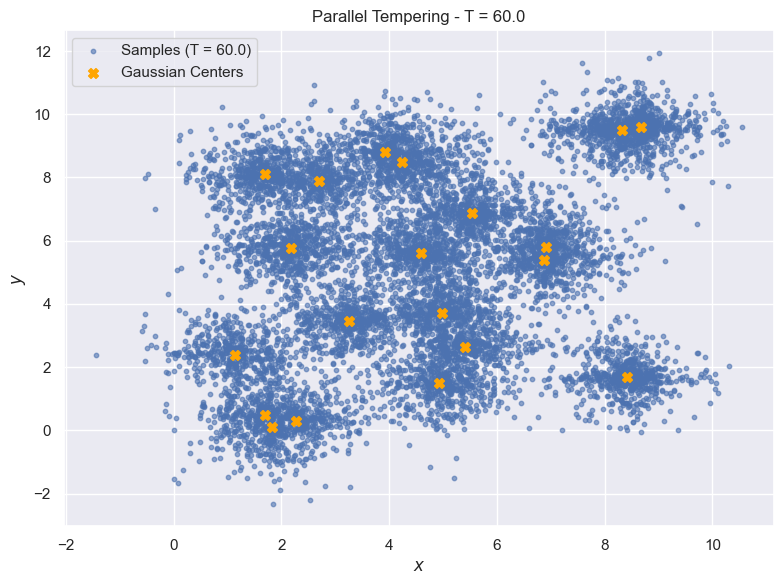

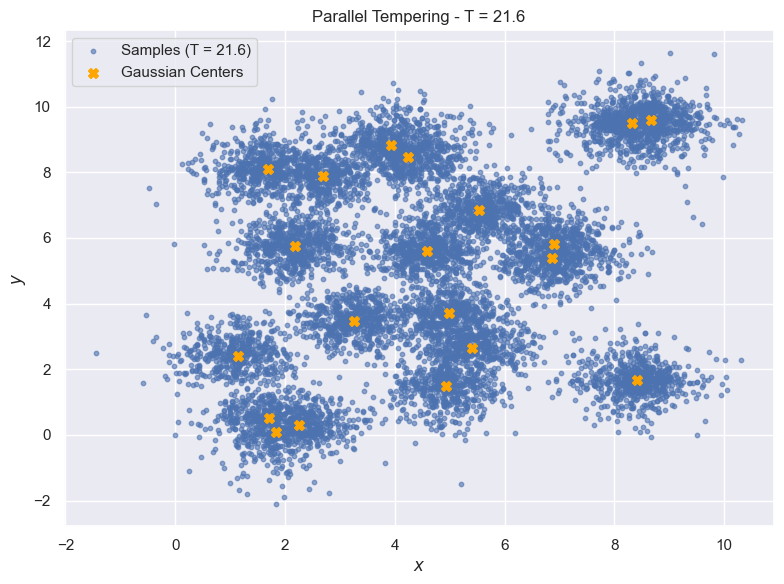

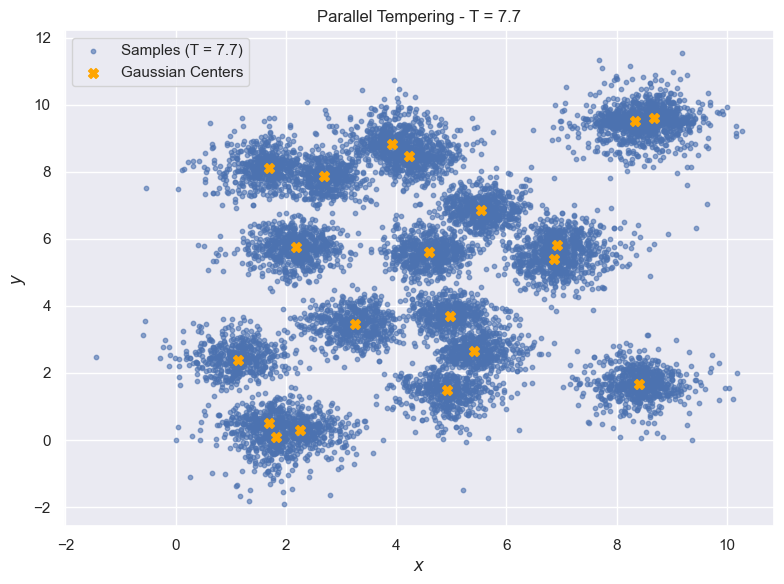

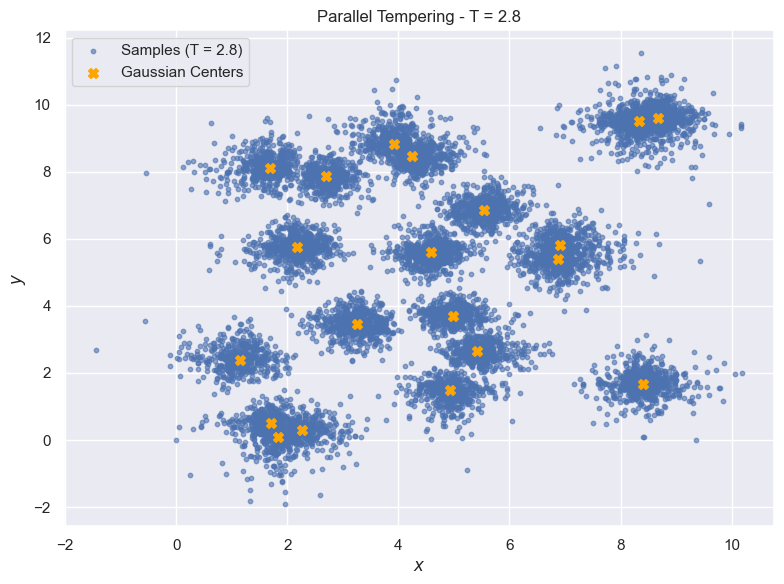

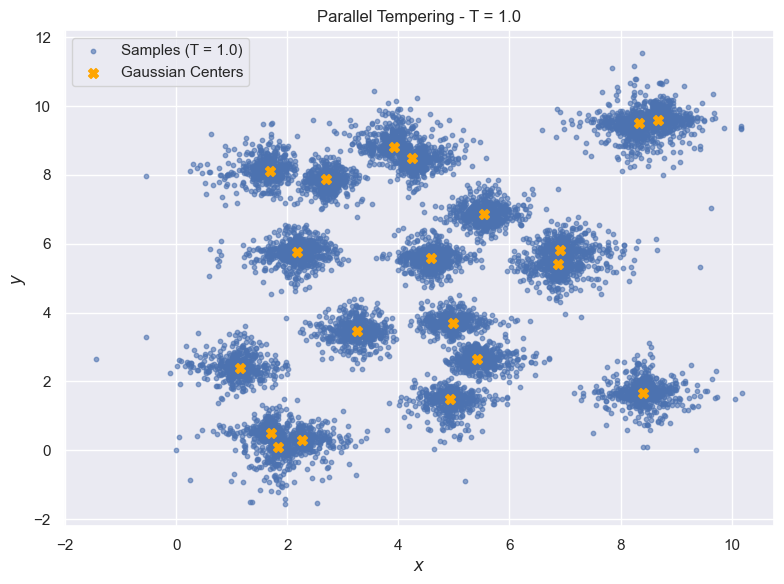

In [59]:
def plot_results_tempering(temperatures, chain_index, samples, means):
    """
    Plots the results for a specific chain in the parallel tempering algorithm.

    Parameters:
    - temperatures: Array of temperatures for each chain.
    - chain_index: Index of the chain to plot.
    - samples: Array of samples (shape: [num_chains, 2, num_iterations + 1]).
    - means: Array of mean vectors for each Gaussian component.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(samples[chain_index, 0, :], samples[chain_index, 1, :], 
                label=f"Samples (T = {temperatures[chain_index]})", alpha=0.6, s=10)
    plt.scatter(means[:, 0], means[:, 1], label='Gaussian Centers', color='orange', marker='X', s=50)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title(f"Parallel Tempering - T = {temperatures[chain_index]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot results for all chains
for chain_idx in range(len(temperatures)):
    plot_results_tempering(temperatures, chain_idx, samples, means)


**Observation:**

The tempering algorithm demonstrates excellent performance with our distribution π, successfully sampling from all 20 Gaussian components across all tempering cases.
It is evident that the effectiveness of the Parallel Tempering algorithm heavily relies on selecting an appropriate temperature ladder, the number of chains, and the proposal kernels.
However, tuning these parameters can be challenging for many distributions. This issue can be addressed by implementing an adaptive version of the Parallel Tempering algorithm.

---

## Exercise 3 : <center> Bayesian analysis of a one-way random effects model

#### Question1.

In this first question, we compute the density of the _a posteriori_ distribution $(X, \mu, \sigma^2, \tau^2)$ up to a normalizing constant.

* $q(X, \mu, \sigma^2, \tau^2|Y) \propto p(Y|X, \mu, \sigma^2, \tau^2) ~\times~ \underbrace{p(X, \mu, \sigma^2, \tau^2)}_{p(X| \mu, \sigma^2, \tau^2) ~\times~ \pi_{prior}(\mu, \sigma^2, \tau^2)}$ <br><br>
$ ~~~~~~~~~~~~~~~~~~~~~~~~~~~ \propto p(Y|X, \mu, \sigma^2, \tau^2) ~\times~ p(X| \mu, \sigma^2, \tau^2) ~\times~ \pi_{prior}(\mu, \sigma^2, \tau^2)$ <br><br>

Therefore, the density of the _a posteriori_ distribution $(X, \mu, \sigma^2, \tau^2)$ is proportional to: <br>

$$ \frac{1}{\tau^k} exp(\sum_{i=1}^N \sum_{j=1}^{k_i}-\frac{(y_{i,j} - X_i)^2} {2\tau^2}) ~~~ \frac{1}{\sigma^N} exp(\sum_{i=1}^N -\frac{(X_i - \mu)^2}{2\sigma^2}) ~~~  \frac{1}{\sigma^{2(1+\alpha)}} exp(-\frac{\beta}{\sigma^2}) ~~~  \frac{1}{\tau^{2(1+\gamma)}} exp(-\frac{\beta}{\tau^2})$$

$$\Longleftrightarrow$$

$$\boxed{ q(X, \mu, \sigma^2, \tau^2|Y) \propto \frac{1}{\tau^{(k + 2(1+\gamma))}}~~\frac{1}{\sigma^{(N+2(1+\alpha))}}~~ exp(\sum_{i=1}^N \sum_{j=1}^{k_i}-\frac{(y_{i,j} - X_i)^2} {2\tau^2}) ~~~  exp(\sum_{i=1}^N -\frac{(X_i - \mu)^2}{2\sigma^2}) ~~~ exp(-\frac{\beta}{\sigma^2}) ~~~ exp(-\frac{\beta}{\tau^2})}$$

#### Question2.

In this question, we implement a **Gibbs sampler** to sample from a 4-dimentional distribution: the sampler updates in turn $(\sigma^2, \tau^2, \mu, X)$ one at a time.

To do so, we start by computing all the full conditional distributions. <br>
We denote by $\theta = (\theta_1, \theta_2, \theta_3, \theta_4) = (\sigma^2, \tau^2, \mu, X)$


* **1. $~~~ p(\theta_1|\theta_{-1}, Y) = p(\sigma^2|X,\mu,\tau^2, Y)$** <br>
* **2. $~~~ p(\theta_2|\theta_{-2}, Y) = p(\tau^2|X,\mu,\sigma^2, Y)$** <br>
* **3. $~~~ p(\theta_3|\theta_{-3}, Y) = p(\mu|X,\sigma^2,\tau^2, Y)$** <br>
* **4. $~~~ p(\theta_4|\theta_{-4}, Y) = p(X|\mu,\sigma^2,\tau^2, Y)$** <br>


**1.** We update first $\sigma^2$ following: 
$$\frac{1}{\sigma^{N+2(1+\alpha)}}~exp(\sum_{i=1}^N - \frac{(X_i-\mu)^2}{2\sigma^2}) ~exp(-\frac{\beta}{\sigma^2})$$
$$\Longleftrightarrow$$
$$\frac{1}{(\sigma^2)^{(\frac{N}{2}+\alpha)+1}} exp(- \frac{(\sum_{i=1}^N \frac{(X_i - \mu)^2}{2}+\beta)}{\sigma^2})~~ (1)$$

**2.** Next, we update  $\tau^2$ following: 
$$\frac{1}{\tau^{k+2(1+\gamma)}} ~exp(\sum_{i=1}^N \sum_{j=1}^{k_i} - \frac{(y_{i,j}-X_i)^2}{2\tau^2}) ~exp(-\frac{\beta}{\tau ^2})$$
$$\Longleftrightarrow$$
$$\frac{1}{(\tau^2)^{(\frac{k}{2}+\gamma)+1}} exp(-\frac{((\sum_{i=1}^N\sum_{j=1}^{k_i}\frac{(y_{i,j}-X_i)^2}{2})+\beta)}{\tau^2})~ (2)$$

**3.** Then, we update  $\mu$ following: 
$$exp(\sum_{i=1}^N -\frac{(X_i - \mu)^2}{2\sigma^2})$$
$$\Longleftrightarrow$$
$$exp(-\frac{(\mu-\frac{\sum_{i=1}^N X_i}{N})^2}{2 \frac{\sigma^2}{N}}) ~~ (3)$$

**4.** Finally, we update  $X$ following: 
$$exp(\sum_{i=1}^N \sum_{j=1}^{k_i} - \frac{(y_{i,j}-X_i)^2}{2\tau^2}) ~ exp(\sum_{i=1}^N -\frac{(X_i - \mu)^2}{2\sigma^2}) ~~~~ (4)$$


We can notice that:
* $(1) ~ \implies~ \sigma^2$ is updated following the Inverse Gamma distribution with parameters $(a = \frac{N}{2} + \alpha,~b= \frac{\sum_{i=1}^N (X_i - \mu)^2}{2}+ \beta)$.

* $(2) ~ \implies~ \tau^2$ is updated following the Inverse Gamma distribution with parameters $(a=\frac{k}{2} + \gamma, ~b=\frac{\sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j}-X_i)^2}{2}+ \beta)$.

* $(3) ~ \implies~ \mu$ is updated following the Gaussian distribution with parameters $(\frac{\sum_{i=1}^N X_i}{N}, \frac{\sigma^2}{N})$.

* $(4) ~ \implies~ X$ is updated following the Gaussian distribution for each of its components $X_i$ with parameters $(\frac{\tau^2 \mu + \sigma^2 \sum_{j=1}^{k_i} y_{i,j} }{k_i \sigma^2 + \tau^2}, \frac{\sigma^2 \tau^2}{k_i \sigma^2 +\tau^2})$.


In [60]:
def gibbs_sampler(Y, N, k, theta, alpha, beta, gamma, num_samples):
    """
    Performs Gibbs sampling for the given model.

    Parameters:
    - Y: Observation matrix (numpy array of shape [N, k]).
    - N: Number of observations (rows of Y).
    - k: Number of variables (columns of Y).
    - theta: Initial values for parameters (sigma2, tau2, mu, x).
    - alpha: Hyperparameter for the prior of sigma2.
    - beta: Hyperparameter for the prior of tau2.
    - gamma: Hyperparameter for the prior of tau2.
    - num_samples: Number of samples to generate.

    Returns:
    - thetas: Tuple containing lists of sampled values for (sigma2, tau2, mu, x).
    """
    # Unpack initial parameter values
    sigma2, tau2, mu, x = theta

    # Initialize lists to store samples
    sigma2_samples, tau2_samples, mu_samples, x_samples = [], [], [], []

    # Loop over the given number of samples
    for _ in tqdm(range(num_samples), desc="Sampling Progress"):
        # 1. Update sigma2: Sample from the full conditional distribution
        a_sigma = N / 2 + alpha
        b_sigma = np.sum((x - mu)**2) / 2 + beta
        sigma2 = 1 / np.random.gamma(a_sigma, 1 / b_sigma)

        # 2. Update tau2: Sample from the full conditional distribution
        a_tau = k * N / 2 + gamma
        b_tau = np.sum((Y.T - x)**2) / 2 + beta
        tau2 = 1 / np.random.gamma(a_tau, 1 / b_tau)

        # 3. Update X: Sample from the full conditional distribution for each observation
        for j in range(N):
            mean_x_j = (tau2 * mu + sigma2 * np.sum(Y[j, :])) / (k * sigma2 + tau2)
            cov_x_j = (sigma2 * tau2)**0.5 / (k * sigma2 + tau2)
            x[j] = np.random.normal(mean_x_j, cov_x_j)

        # 4. Update mu: Sample from the full conditional distribution
        mean_mu = np.mean(x)
        cov_mu = np.sqrt(sigma2 / k)
        mu = np.random.normal(mean_mu, cov_mu)

        # Save the computed parameters for each sample
        sigma2_samples.append(sigma2)
        tau2_samples.append(tau2)
        mu_samples.append(mu)
        x_samples.append(x.copy())

    # Package results into a tuple
    thetas = (sigma2_samples, tau2_samples, mu_samples, x_samples)
    return thetas


#### Question3.

In this question, we'll implement a Block-Gibbs sampler which updates $\sigma^2$, then $\tau^2$ and then the block $(X, \mu)$.

To do so, we start by computing all the full conditional distributions. <br>
We denote by $\theta = (\theta_1, \theta_2, \theta_3) = (\sigma^2, \tau^2, (X,\mu))$
<br>
* We have already computed $~~ p(\theta_1|\theta_{-1}, Y) = p(\sigma^2|X,\mu,\tau^2, Y)$ and $p(\theta_2|\theta_{-2}, Y) = p(\tau^2|X,\mu,\sigma^2, Y)$. <br>
* We compute $~~ p(\theta_3|\theta_{-3}, Y) =p(X,\mu|\sigma^2, \tau^2, Y)$.
<br><br>

**1-2.** We update first $\sigma^2$, then, we update $\tau^2$ following the same distributions as previously.

**3.** Then, we update the block $(X, \mu)$ following:
$$\ exp(\sum_{i=1}^N \sum_{j=1}^{k_i} -\frac{(y_{i,j}-X_i)^2}{2\tau^2}) ~exp( - \sum_{i=1}^N \frac{(X_i-\mu)^2}{2\sigma^2}) ~~~~~~ (5)$$

We can notice that :    
* $(5) ~ \implies~ \forall i \in [1,\mathbb{N}], (X_i, \mu)$ is updated following a multivariate gaussian distribution with mean `mean` and covariance matrix `cov`.

In [ ]:
def block_gibbs_sampler(Y, N, k, theta, alpha, beta, gamma, num_samples): 
    """
    Performs Block Gibbs Sampling for the given model.


    Returns:
    - thetas: Tuple containing lists of sampled values for (sigma2, tau2, mu, x).
    """
    # Unpack initial parameter values
    sigma2, tau2, mu, x = theta

    # Initialize lists to store samples
    sigma2_samples, tau2_samples, mu_samples, x_samples = [], [], [], []

    # Sampling loop
    for _ in tqdm(range(num_samples), desc="Block Gibbs Sampling Progress"):
        # 1. Update sigma2: Sample from the full conditional distribution
        a_sigma = N / 2 + alpha
        b_sigma = np.sum((x - mu)**2) / 2 + beta
        sigma2 = 1 / np.random.gamma(a_sigma, 1 / b_sigma)

        # 2. Update tau2: Sample from the full conditional distribution
        a_tau = k * N / 2 + gamma
        b_tau = np.sum((Y.T - x)**2) / 2 + beta
        tau2 = 1 / np.random.gamma(a_tau, 1 / b_tau)

        # 3. Update block (X, mu)
        covariance = compute_covariance_matrix(N, k, sigma2, tau2)
        y_sum = np.sum(Y, axis=1)
        y_sum = np.append(y_sum, 0)  # Append 0 for mu's position
        mean = covariance @ (y_sum / tau2)
        block = np.random.multivariate_normal(mean, covariance).reshape((N + 1,))
        x = block[:N]
        mu = block[N]

        # Save computed parameters for each sample
        sigma2_samples.append(sigma2)
        tau2_samples.append(tau2)
        mu_samples.append(mu)
        x_samples.append(x)

    thetas = (sigma2_samples, tau2_samples, mu_samples, x_samples)
    return thetas


In [ ]:
def compute_covariance_matrix(N, k, sigma2, tau2):
    """
    Computes the covariance matrix for the block update (X, mu).

    Returns:
    - covariance_matrix: The covariance matrix for the block update.
    """
    # Initialize diagonal and inverse covariance matrix
    diagonal = np.zeros(N + 1)
    inverse_cov = np.zeros((N + 1, N + 1))
    diag_indices = np.diag_indices(N + 1)

    for i in range(N):
        diagonal[i] = (k * sigma2 + tau2) / (sigma2 * tau2)
        inverse_cov[N, i] = -1 / sigma2
        inverse_cov[i, N] = -1 / sigma2

    diagonal[N] = N / sigma2
    inverse_cov[diag_indices] = diagonal
    inverse_cov[N, N] = N / sigma2

    # Return the inverse of the inverse covariance matrix
    return np.linalg.inv(inverse_cov)

#### Question4.

**Discussion of the theoretical performance of the two algorithms:**

The standard Gibbs Sampler converges to the true distribution at a very slow pace, often requiring significantly more steps. In some cases, it may become computationally impractical within a reasonable timeframe. This slow convergence can be attributed to the curse of dimensionality. The Block Gibbs Sampler addresses this issue by leveraging its theoretical structure to sample multiple coupled (as in this exercise) or grouped variables simultaneously.
Additionally, this approach is well-suited for handling highly complex problems and can also help in reducing auto-correlation.

#### Question5.

In this question, we test our code on a synthetic dataset $Y = \{~ y_{i,j} , ~i \in [1, \mathbb{N}], ~j \in [1, k_i]~\}$ generated from the previous model.

**Compute synthetic data.**

In [63]:
def synthetic_dataset(N, k, mu, sigma2, tau2):
    """
    Generates a synthetic dataset based on the given parameters.

    Returns:
    - Y: A numpy array of shape (N, k) containing the generated dataset.
    """
    # Initialize the dataset
    Y = np.zeros((N, k))

    for i in range(N):
        # Sample X_i from N(mu, sigma2)
        X_i = np.random.normal(mu, np.sqrt(sigma2))

        # Add noise to each column and populate Y
        Y[i, :] = X_i + np.random.normal(0, np.sqrt(tau2), size=k)

    return Y


In [64]:
# Generate the synthetic dataset
Y = synthetic_dataset(N=1000, k=5, mu=3.0, sigma2=1.0, tau2=0.01)

# Inspect the generated dataset
print(Y.shape)  # Should output (1000, 5)
print(Y[:5, :])  # Display the first 5 rows for verification


(1000, 5)
[[3.21106341 3.39058966 3.21790771 3.41002977 3.23497279]
 [3.86293661 3.93784558 3.80468336 3.79411592 3.63748824]
 [2.80857381 2.82565833 2.68805323 2.64559827 2.82818444]
 [1.87261507 1.97702636 1.66529335 2.02501377 1.59843666]
 [2.67342017 2.47444375 2.53110971 2.28275187 2.59503525]]


**Define hyper-parameters.**

In [65]:
# Known hyperparameters
alpha = 0.01  # Hyperparameter for the prior of sigma2
beta = 0.01   # Hyperparameter for the prior of tau2
gamma = 0.01  # Hyperparameter for the prior of tau2


**Apply Gibbs sampler.**

In [70]:
from tqdm import tqdm


In [71]:
# Initial parameter values
theta0 = [2, 1, 1, np.zeros(1000)]  # Initial values for sigma2, tau2, mu, and X

# Perform Gibbs sampling
sigma2_samples, tau2_samples, mu_samples, X_samples = gibbs_sampler(
    Y=Y,
    N=1000,
    k=5,
    theta=theta0,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    num_samples=10000
)

# Display results
print(f"Number of sigma2 samples: {len(sigma2_samples)}")
print(f"Number of tau2 samples: {len(tau2_samples)}")
print(f"Number of mu samples: {len(mu_samples)}")
print(f"Number of X samples: {len(X_samples)}")

# Inspect the first few samples for sigma2
print("First few sigma2 samples:", sigma2_samples[:5])

# Inspect the first few samples for tau2
print("First few tau2 samples:", tau2_samples[:5])

# Inspect the first few samples for mu
print("First few mu samples:", mu_samples[:5])



























































































































































































































































































































































































Sampling Progress: 100%|██████████| 10000/10000 [00:38<00:00, 257.27it/s]

Number of sigma2 samples: 10000
Number of tau2 samples: 10000
Number of mu samples: 10000
Number of X samples: 10000
First few sigma2 samples: [0.9997599064809355, 0.27813945957959035, 0.2628097554962605, 0.47541092099967475, 0.8980950769096276]
First few tau2 samples: [9.673309143463939, 2.115018472889197, 0.7517853332440436, 0.1974023806657307, 0.026688280859393763]
First few mu samples: [1.998764913811162, 2.5558702490911758, 2.8107571130544935, 3.1834029157922927, 2.855870658133676]


**Apply Block Gibbs sampler.**

In [73]:
# Initial parameter values
theta0 = [2, 0.1, 1, np.zeros(1000)]  # Initial values for sigma2, tau2, mu, and X

# Perform Block Gibbs Sampling
sigma2_block_samples, tau2_block_samples, mu_block_samples, X_block_samples = block_gibbs_sampler(
    Y=Y,
    N=1000,
    k=5,
    theta=theta0,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    num_samples=2000
)

# Display results
print(f"Number of sigma2 block samples: {len(sigma2_block_samples)}")
print(f"Number of tau2 block samples: {len(tau2_block_samples)}")
print(f"Number of mu block samples: {len(mu_block_samples)}")
print(f"Number of X block samples: {len(X_block_samples)}")

# Inspect the first few samples for sigma2
print("First few sigma2 block samples:", sigma2_block_samples[:5])

# Inspect the first few samples for tau2
print("First few tau2 block samples:", tau2_block_samples[:5])

# Inspect the first few samples for mu
print("First few mu block samples:", mu_block_samples[:5])
































































































































































































Block Gibbs Sampling Progress:   9%|▉         | 189/2000 [07:32<1:12:13,  2.39s/it]
Exception ignored in: <function tqdm.__del__ at 0x127271700>
Traceback (most recent call last):
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x127271700>
Traceback (most recent call last):
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/samar/Library/Python/3.9/lib/python/site-packages/tqdm/notebook.

KeyboardInterrupt: 

**Autocorrelation:**

In [ ]:
def plot_autocorrelation(mu, sigma2, tau2, algorithm_name):
    """
    Plots the autocorrelation for the given parameters from the sampling algorithm.

    """
    plt.figure(figsize=(10, 6))
    pd.plotting.autocorrelation_plot(pd.DataFrame(mu), label='Autocorrelation of mu')
    pd.plotting.autocorrelation_plot(pd.DataFrame(sigma2), label='Autocorrelation of sigma2')  
    pd.plotting.autocorrelation_plot(pd.DataFrame(tau2), label='Autocorrelation of tau2')
    plt.legend()
    plt.xlim((0, 100))
    plt.title(f'Autocorrelation Plot - {algorithm_name}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Auto-correlation of parameters from Gibbs sampler
plot_autocorrelation(mu_samples, sigma2_samples, tau2_samples, 'Gibbs Sampler')

# Auto-correlation of parameters from Block Gibbs sampler
plot_autocorrelation(mu_block_samples, sigma2_block_samples, tau2_block_samples, 'Block Gibbs Sampler')


NameError: name 'mu_samples' is not defined

---